<font size="5">ライブラリのインポート

In [1]:
!pip install japanize-matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import csv

<font size="5">cpuとgpuの選択

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "gpu")

<font size="5">乱数を特定の値にして再現性を確保

In [4]:
# For reproducibility
torch.manual_seed(42)
if use_cuda:
    torch.cuda.manual_seed(42)

<font size ="5">pytorch用データセットの作成

In [5]:
# Load MNIST dataset
# pytorchではTensorというデータ構造で、モデルの入力、出力、パラメータを表現
# 前処理の定義
"""
これから取得するDatasetの中身がndarray型のデータ集合であるため、前処理でtensor型にしたい

root
Datasetを参照(または保存)するディレクトリを「path」の部分に指定する.
そのディレクトリに取得したいDatasetが存在すればダウンロードせずにそれを使用する.

train
Training用のdataを取得するかどうかを選択する.
FalseにすればTest用のdataを取得するが,この2つの違いはdata数の違いと思ってくれて良い.

download
rootで参照したディレクトリにDatasetがない場合ダウンロードするかどうかを決めることができる.

transform
定義した前処理を渡す.
こうすることでDataset内のdataを参照する時にその前処理を自動で行ってくれる.
"""
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 学習用データとテスト用データの取得
# transformは私用すると前処理を指定できる
# これによりdatasetをdetaloaderに渡して使える状態にした
train_dataset_original = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
print(f"Train Dataset Size: {len(train_dataset_original)}")
test_dataset_original = datasets.FashionMNIST(root='./data', train=False, transform=transform)
print(f"Test Dataset Size: {len(test_dataset_original)}")

Train Dataset Size: 60000
Test Dataset Size: 10000


C:\Users\y9723\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<font size ="5">データの個数を調節

In [6]:
# traindata
# クラス数を取得
num_classes = len(train_dataset_original.classes)
print(num_classes)
print(len(train_dataset_original))
# 各クラスごとのデータ数を計算
desired_class_count = 3000  # 各クラスごとに均等に分割したいデータ数
total_desired_count = desired_class_count * num_classes

# クラスごとに均等にデータを分割するためのリストを作成
selected_indices_1 = []
selected_indices_2 = []

# 各クラスごとに均等にデータを選択
for class_idx in range(num_classes):
    class_indices = np.where(train_dataset_original.targets == class_idx)[0]
    np.random.shuffle(class_indices)
    selected_indices_1.extend(class_indices[:desired_class_count])
    selected_indices_2.extend(class_indices[desired_class_count:2*desired_class_count])

# 選択したデータで新しいデータセットを作成
train_data_1 = torch.utils.data.Subset(train_dataset_original, selected_indices_1)
train_data_2 = torch.utils.data.Subset(train_dataset_original, selected_indices_2)

# # 各クラスごとの新しいデータ数を確認
class_counts_subset_1 = np.bincount([train_dataset_original.targets[i] for i in selected_indices_1])
class_counts_subset_2 = np.bincount([train_dataset_original.targets[i] for i in selected_indices_2])

print("データセット1の各クラスごとの新しいデータ数:", class_counts_subset_1)
print("データセット2の各クラスごとの新しいデータ数:", class_counts_subset_2)

# testdata
# 2. データセット内のクラスごとのサンプル数を確認
class_count = [0] * 10# 10はFashionMNISTのクラス数です
sample_indices = []
for i in range(len(test_dataset_original)):
    _, target = test_dataset_original[i]
    if class_count[target] < 100:  # 各クラスから100サンプルまで抽出
        sample_indices.append(i)
        class_count[target] += 1

# 3. 均等に抽出されたサンプルから新しいデータセットを構築
test_data = torch.utils.data.Subset(test_dataset_original, sample_indices)

# 新しいデータセットを使用して必要な処理を実行

for i in range(len(test_data)):
    if class_count[target] < 100:  # 各クラスから100サンプルまで抽出
        sample_indices.append(i)
        class_count[target] += 1

# 各クラスごとのサンプル数を出力
for i, count in enumerate(class_count):
    print(f"クラス {i}: {count} 個のサンプル")
    
print(f"testデータの数：{len(test_data)}")

10
60000
データセット1の各クラスごとの新しいデータ数: [3000 3000 3000 3000 3000 3000 3000 3000 3000 3000]
データセット2の各クラスごとの新しいデータ数: [3000 3000 3000 3000 3000 3000 3000 3000 3000 3000]
クラス 0: 100 個のサンプル
クラス 1: 100 個のサンプル
クラス 2: 100 個のサンプル
クラス 3: 100 個のサンプル
クラス 4: 100 個のサンプル
クラス 5: 100 個のサンプル
クラス 6: 100 個のサンプル
クラス 7: 100 個のサンプル
クラス 8: 100 個のサンプル
クラス 9: 100 個のサンプル
testデータの数：1000


<font size ="5">Siamese Network用MNISTデータセットクラスの作成

In [7]:
# Siamese Network用MNISTデータセットクラスの作成
class SiameseMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset=dataset
        self.length=len(self.dataset)
        self.pair_index=[]     # Siamese Net用画像ペアインデックス配列
        labels=[label for _, label in self.dataset]     # 入力されたデータセットからラベル情報のみ抽出
        positive_count=0     # positiveペアのカウント
        negative_count=0     # negativeペアのカウント
        random_index=np.arange(self.length)     # ？？？
        
        while positive_count + negative_count < self.length:
            np.random.shuffle(random_index)
            for i in np.arange(self.length):
                if labels[i]==labels[random_index[i]]:     # 画像ペアのラベルが等しい時（positive）
                    if positive_count<self.length/2:      # おそらく比率を同じにしたい？？
                        self.pair_index.append([i, random_index[i], 1])      # 要素の構成：[<画像1のインデックス>,<画像2のインデックス>,<posi:1/nega:0フラグ>]
                        positive_count+=1
                    else:
                        continue
                else:
                    if negative_count<self.length/2:
                        self.pair_index.append([i, random_index[i], 0])
                        negative_count+=1
                    else:
                        continue
#         print("com", self.pair_index)
    def __len__(self):
        return self.length

    def __getitem__(self, index):

        return self.dataset[self.pair_index[index][0]][0], self.dataset[self.pair_index[index][1]][0], torch.tensor(self.pair_index[index][2])

<font size ="5">Siamese Network学習用Dataset, DataLoaderの作成

In [8]:
batch_size=64
# 1 学習用
# train_dataset_1=SiameseMNIST(train_data_1) 
# train_data_learn=DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
# # # 2 写像用(領域作成用)
# # train_data_projection=DataLoader(train_data_2, batch_size=1, shuffle=True)
# 3 テスト用
# test_loader=DataLoader(test_data, batch_size=1, shuffle=True)

batch_size=64
train_dataset=SiameseMNIST(train_dataset_original) 
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_prime=DataLoader(train_dataset_original, batch_size=1, shuffle=False)

In [9]:
test_loader=DataLoader(test_data, batch_size=1, shuffle=False)

<font size ="5">ペア画像の確認

torch.Size([1, 28, 28])
y[0]=1
y[1]=1
y[2]=1
y[3]=1
y[4]=1
y[5]=1
y[6]=0
y[7]=0
y[8]=0
y[9]=0


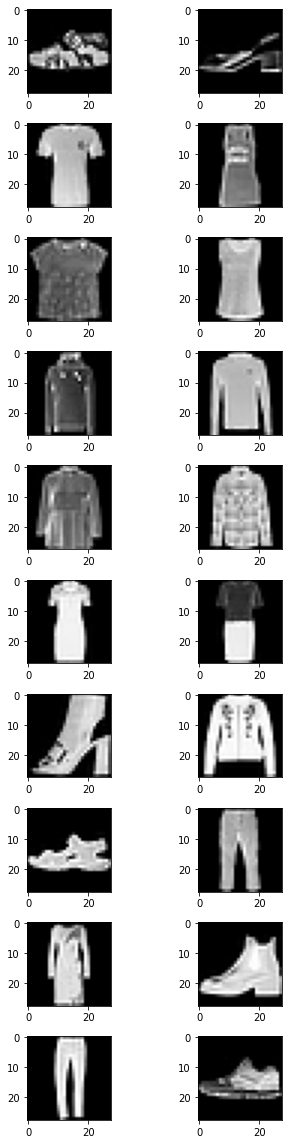

In [10]:
X1, X2, y = next(iter(train_loader))
print(X1[0].shape)
fig=plt.figure(tight_layout=True, figsize=(8, 16))
rows=10
for i in range(rows):
    print(f"y[{i}]={y[i]}")
    ax = fig.add_subplot(rows, 2, i*2+1)
    ax.imshow(X1[i][0].numpy(), cmap='gray')                          # X1[i].shape = (1, 28, 28)，X1[i][0].shape = (28, 28)
    ax = fig.add_subplot(rows, 2, i*2+2)
    ax.imshow(X2[i][0].numpy(), cmap='gray') 

<font size="5">モデルの構築

super()はあるクラス（子クラス）で別のクラス（親クラス）を継承できる。継承することで、親クラスのメソッドを子クラスから呼び出すことができる。
以下の形式
super().親クラスのメソッド

In [11]:
class BaseNetwork(nn.Module):
    """
    Base network for Siamese Network.
    This will be shared between two input images.
    """
    def __init__(self):
        super().__init__()

        # Define the layers
        # Using similar architecture as in the Keras example

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten and Dense Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Assuming input image size is 28x28
        self.act3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 256)
        self.act4 = nn.ReLU()

    def forward_1(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.dropout(x)
        x = self.fc2(x)
#         print("xのshape",x)
        x = self.act4(x)

        return x

    def forward(self, x1,x2):
        z1=self.forward_1(x1)
        z2=self.forward_1(x2)
        return z1,z2

# Test the base network with a sample input
base_network = BaseNetwork().to(device)
sample_input = torch.randn(8, 1, 28, 28).to(device)  # Batch of 8 images of sizammm28x28 with 1 channel
sample_output = base_network.forward_1(sample_input)

sample_output.shape  # Expected: [8, 256]


C:\Users\y9723\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([8, 256])

In [12]:
# Siamse Networkモデルクラス
import torch.nn as nn

class SiameseCNNMnistModel(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2), # 28x28x32
            nn.ReLU(),
            nn.MaxPool2d(2,2),                         # 14x14x32
            nn.Conv2d(32, 64, kernel_size=5, padding=2),# 14x14x64
            nn.ReLU(),
            nn.MaxPool2d(2,2)                          # 7x7x64
        )

        # Fully connected layers to get embeddings
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )
    
    def forward_once(self, x):
        x = self.encoder(x)
        x = x.view(x.size()[0], -1)  # Flatten
        z = self.fc(x)
        return z
  
    def forward(self, x1, x2):
        z1 = self.forward_once(x1)
        z2 = self.forward_once(x2)
        return z1, z2


<font size="5">損失関数

In [13]:
# 損失関数
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z1, z2, y):
        difference = z1 - z2
        distance_squared = torch.sum(torch.pow(difference, 2), 1)
        distance = torch.sqrt(distance_squared)       #平均：0.813，最大：1.663，最小：0.023，中央値：0.492
        negative_distance = self.margin - distance
        negative_distance = torch.clamp(negative_distance, min=0.0)
        loss = (abs(y) * (distance_squared+2) + abs(1 - abs(y)) * torch.pow(negative_distance, 2)) / 2.0
        loss = torch.sum(loss) / z1.size()[0]
        return loss

<font size ="5">使用関数の一覧実行

<font size ="5">学習の準備

In [14]:
import torch.optim as optim
from torchsummary import summary

#モデルのインスタンス化
model=SiameseCNNMnistModel().to(device)
print(model.parameters)
# ？？？？
summary(model, input_size=[(1, 28, 28), (1, 28, 28)])      # 入力が２つあるので（ペア画像だから）input_sizeはリストで複数指定する

# 最適化関数の定義
optimizer=optim.SGD(model.parameters(), lr=0.05)

# 損失関数のインスタンス化
criterion=ContrastiveLoss()

<bound method Module.parameters of SiameseCNNMnistModel(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              

<font size ="5">学習の実行

In [15]:
# import copy
# import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm

# # モデル学習
# repeat = 60                                                      # 学習回数
# losses = []                                                       # 表示用損失値配列

# model.train()                                                     # 学習モード
# for epoch in range(repeat): 
#   print(f"epoch={epoch}")
#   nan_count = 0
#   normal_count = 0




#   # tqdmを使って学習の進行状況を表示
#   for X1, X2, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{repeat}"):                                  
#     # モデルによる特徴ベクトル算出
#     output1, output2 = model(X1.to(device), X2.to(device))

#     # 損失関数の計算
#     loss = criterion(output1, output2, y.to(device))

#     # nan対策（lossにnanが含まれていれば１回前のモデルに戻す）
#     if torch.isnan(loss):
#       model = prev_model
#       optimizer = optim.SGD(model.parameters(), lr=0.05)
#       optimizer.load_state_dict(prev_optimizer.state_dict())
#       nan_count += 1
#       continue
#     else:
#       prev_model = copy.deepcopy(model)
#       prev_optimizer = copy.deepcopy(optimizer)
#       normal_count += 1

#     # 表示用lossデータの記録
#     losses.append(loss.item())

#     # 勾配を初期化
#     optimizer.zero_grad()
    
#     # 損失関数の値から勾配を求め誤差逆伝播による学習実行
#     loss.backward()
    
#     # 学習結果に基づきパラメータを更新
#     optimizer.step()

#   print(f"nan/normal: {nan_count}/{normal_count}")
# plt.plot(losses)                                                  # loss値の推移を表示


<font size ="5">学習結果の保存

In [16]:
# torch.save(model.state_dict(), 'model_weights_Epochs_60_Margin_2_5_Alpha_02.pth')

<font size ="5">学習済みの重みを再利用する場合

In [17]:
model.load_state_dict(torch.load('model_weights_epochs_60_margin_2.5.pth'))

<All keys matched successfully>

<font size ="5">モデルの出力ベクトルの取得

モデル学習の結果、同じクラスに属する画像の出力ベクトルは近くに、異なる数字に属する画像の出力ベクトルは遠くに配置されているはず。
これを確認するために、テストデータを用いて出力ベクトルを集める。
model.eval()で評価モードに設定し、変数の勾配も再計算されないようにtorch.no_grid()を記述する。

In [18]:
# モデル評価
model.eval()                                                      # 評価モード
with torch.no_grad():
    z_valid = []
    y_valid = []
    for X, y in train_loader_prime:                                      # テスト用DataLoader
        z_valid.append(model.forward_once(X.to(device)))           # テストデータをモデルに通して出力ベクトルを得る
        y_valid.append(y)                                          # ラベル（靴、シャツ）の代わりにラベルIDとして0～9の数代わり振られている
    z_valid = torch.cat(z_valid, dim=0)                             # 多次元torch.tensor要素のリストをtorch.tensor化
    y_valid = torch.tensor(y_valid)                                 # スカラ要素(int)リストをtorch.tensor化

In [19]:
# 次元数の確認
print(z_valid.size())
print(y_valid.size())

torch.Size([60000, 3])
torch.Size([60000])


z_testとy_testをGPUに移動

In [20]:
# GPUが利用可能かチェック
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# z_validとy_validをGPUに移動
z_valid = z_valid.to(device)
y_valid = y_valid.to(device)
# ndarrayに変換
z_valid_np = z_valid.to('cpu').detach().numpy().copy()
y_valid_np = y_valid.to('cpu').detach().numpy().copy()
print(z_valid_np.shape)
print(y_valid_np.shape)

(60000, 3)
(60000,)


<font size="5">モデル出力ベクトルの分布可視化

<IPython.core.display.Javascript object>


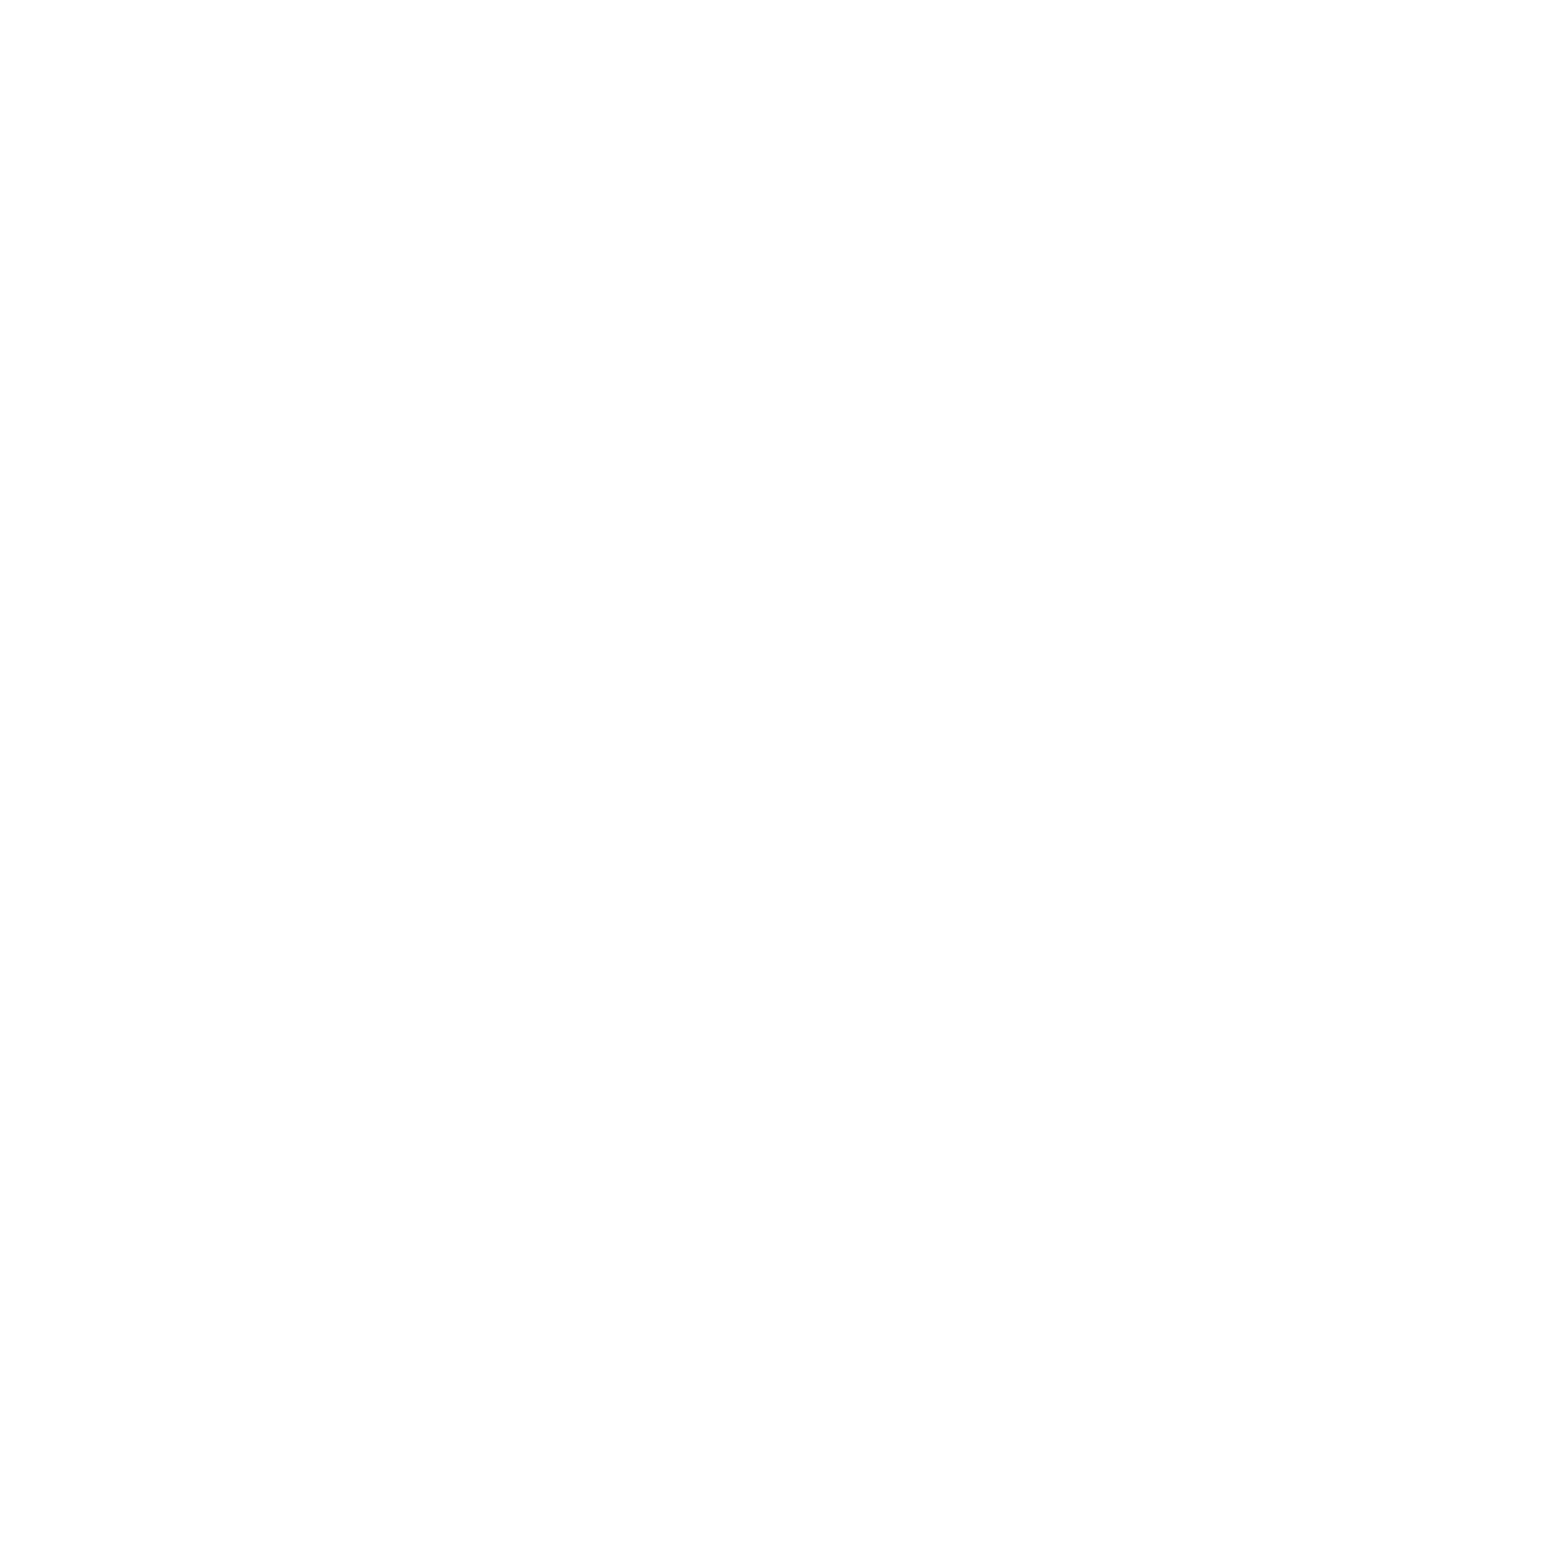

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# クラス名
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# クラス数
class_num=len(class_names)
# 事前に定義された10色のリスト
colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']
# figureを生成する
plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = plt.subplot(111, projection='3d')
# クラスごとに色を分けてプロット
for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i])
ax.legend()  # 凡例の追加
plt.show()

分散の算出

In [22]:
z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2]
# 分散
variance=np.zeros((class_num))

# print(z_valid_np[y_valid_np==0].shape)
for i in range(class_num):
    variance[i]=np.min(np.var(z_valid_np[y_valid_np==i], axis=0), axis=0)
#     print(variance[i])
variance

array([0.05247046, 0.00954384, 0.0774831 , 0.04525571, 0.06263208,
       0.01614965, 0.09755592, 0.01955811, 0.01766576, 0.01332599])

In [23]:
min_value = np.min(variance)
max_value = np.max(variance)

# 正規化
normalized_values = (variance - min_value) / (max_value - min_value)

print(normalized_values)

[0.48773558 0.         0.77193102 0.40576094 0.6031926  0.07505571
 1.         0.11378285 0.0922819  0.0429731 ]


<font size="5">判定領域作成関数

判定領域作成のステップを以下に示す   
１．ノイズクラスタリングにより算出した重心を可視化→処理時間がかかるためデータ数を減らして行う？  
２．重心から領域を広げていく（同心円状に安全マージンの導入をしてみてもいいかも）  
３．重心内の含有量を算出し、一定値以上となった場合広げるのをやめる  
４．以上により三次元空間の判定領域を作成     
→同心円状の場合は、判定領域内かどうかは半径と点同士の距離を測定して算出が可能  

<font size="5">testデータで性能判定

1. CNNから(3,)の出力を受け取る
2, 各クラスタとの距離を算出して最小のものを選択→半径以内かどうか判定（二十判定、判定がない場合に予測不可とする）

In [24]:
# モデル評価
model.eval()                                                      # 評価モード
with torch.no_grad():
    z_test = []
    y_test = []
    for X, y in test_loader:                                      # テスト用DataLoader
#         print(X)
#         print(y)
        z_test.append(model.forward_once(X.to(device)))           # テストデータをモデルに通して出力ベクトルを得る
        y_test.append(y)                                          # ラベル（靴、シャツ）の代わりにラベルIDとして0～9の数代わり振られている
    z_test = torch.cat(z_test, dim=0)                             # 多次元torch.tensor要素のリストをtorch.tensor化
    y_test = torch.tensor(y_test)

# z_testとy_testをGPUに移動
z_test = z_test.to(device)
y_test = y_test.to(device)
# ndarrayに変換
z_test_np = z_test.to('cpu').detach().numpy().copy()
y_test_np = y_test.to('cpu').detach().numpy().copy()
# print(z_test_np.shape)
# print(y_test_np.shape)

<font size="5">testデータに対して判定領域を作成

判定領域作成のステップを以下に示す   
１．testデータを受け取る  
２．testデータからの距離（球、立方体）の領域を獲得、その条件に合うデータを取ってきて、ラベルを確認する  
３．ラベルから領域判定条件を設定する。し、解答を算出

①normal

In [25]:
# 格納用
data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]
# print(string_test_radius)
# level0
level0=string_test_radius
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=60
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level0, level1]
# print(indices)

# データの整理

for index in range(len(test_radius)):
    for l in range(z_test_np.shape[0]):
        # 四角形内か否かを判定
        array=(z_test_np[l]-test_radius[index] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius[index])
    #     print(array.shape)
        array1=array.all(axis=1)
    #     print(array1.shape)
    #     print(array1)
        array2=z_valid_np[array1]   
    #     print(array2.shape)
        # totalの計算
        total_elements=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array1]
    #     print(type(array3))
        counts=np.bincount(array3, minlength=10)
        var_counts=np.copy(counts)
        # 結果の表示
        # 11/26：分散の導入
#         print(counts.shape)
        for i in range(class_num):
            var_counts=counts/variance[i]
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
    #         print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    #     print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
    #     print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
    #     print(f"max_index:{max_index}")
        if para < max_value and total_elements!=0:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
        
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in longlong_scalars


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  Sneaker  \
0.1 正解             80       96        79     79    74      96     69       97   
    不正解            11        2        15      9    11       0     16        1   
    解答不可            9        2         6     12    15       4     15        2   
0.2 正解             82       98        79     83    79     100     70       96   
    不正解             9        1        14      8    10       0     17        2   
    解答不可            9        1         7      9    11       0     13        2   
0.3 正解             83       98        80     84    81      99     70       96   
    不正解            11        1        15      7    10       0     19        2   
    解答不可            6        1         5      9     9       1     11        2   
0.4 正解             82       98        81     85    81     100     68       96   
    不正解            12        1        15      7    11       0     21        2   
    解答不可            6        1         4      8     8       0     11        2   
0.5 正解             85       99        81     85    80     100     66       96   
    不正解            10        1        15      7    11       0     21        3   
    解答不可            5        0         4      8     9       0     13        1   
0.6 正解             85       99        81     85    79     100     66       97   
    不正解            10        1        14      6    11       0     20        3   
    解答不可            5        0         5      9    10       0     14        0   
0.7 正解             85       99        81     85    78     100     63       97   
    不正解            11        1        13      6    11       0     19        3   
    解答不可            4        0         6      9    11       0     18        0   
0.8 正解             85       99        78     85    78     100     59       97   
    不正解            11        1        12      5     8       0     17        3   
    解答不可            4        0        10     10    14       0     24        0   
1   正解             82       99        70     85    68     100     37       97   
    不正解             8        1         7      6     6       0     12        2   
    解答不可           10        0        23      9    26       0     51        1   

          Bag  Ankle boot  
0.1 正解     93          96  
    不正解     0           4  
    解答不可    7           0  
0.2 正解     97          95  
    不正解     0           4  
    解答不可    3           1  
0.3 正解     97          95  
    不正解     1           4  
    解答不可    2           1  
0.4 正解     97          95  
    不正解     1           4  
    解答不可    2           1  
0.5 正解     97          95  
    不正解     2           3  
    解答不可    1           2  
0.6 正解     97          95  
    不正解     2           3  
    解答不可    1           2  
0.7 正解     97          96  
    不正解     1           3  
    解答不可    2           1  
0.8 正解     97          96  
    不正解     2           4  
    解答不可    1           0  
1   正解     97          95  
    不正解     1           3  
    解答不可    2           2

In [26]:
# 格納用
data=[]
uncorrect_data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.2]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]
# print(string_test_radius)
# level0
level0=string_test_radius
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
number_data=np.zeros((z_test_np.shape[0],))
correct_nucorrect=np.zeros((z_test_np.shape[0],))
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=0
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level0, level1]
# print(indices)

# データの整理

for index in range(1):
    for l in range(z_test_np.shape[0]):
        # 四角形内か否かを判定
        array=(z_test_np[l]-test_radius[index] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius[index])
    #     print(array.shape)
        array1=array.all(axis=1)
#         print(array1.shape)
    #     print(array1)
        array2=z_valid_np[array1]   
#         print(array2.shape[0])
        number_data[l]=array2.shape[0]
        # totalの計算
        total_elements=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array1]
    #     print(type(array3))
        counts=np.bincount(array3, minlength=10)
#         var_counts=np.copy(counts)
        # 結果の表示
        # 11/26：分散の導入
#         print(counts.shape)
#         for i in range(class_num):
#             var_counts[i] = counts[i] / variance[i]
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
            print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
        print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
        print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
        print(f"max_index:{max_index}")
        if para < max_value and total_elements != 0:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
    
    number_data=number_data.astype(int)
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            # 代入（可視化用）
            correct_nucorrect[i]=0
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            # 代入（可視化用）
            correct_nucorrect[i]=2
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            # 代入（可視化用）
            correct_nucorrect[i]=1
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            # 不正解を見たい
            uncorrect_data.append(i)
#     print(uncorrect_data)
#     print(len(uncorrect_data))
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 2 回出現しました。割合は 0.06% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 3479 回出現しました。割合は 99.94% です。
--------------------------------------------------------------------
max_value:99.94254524561907
max_index:9
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 72 回出現しました。割合は 96.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 2 回出現しました。割合は 2.67% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 1 回出現しました。割合は 1.33% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:96.0
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 4954 回出現しました。割合は 99.98% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 1 回出現しました

クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:1
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 4968 回出現しました。割合は 99.98% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 1 回出現しました。割合は 0.02% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.9798752264037
max_index:1
クラス 0 は 23 回出現しました。割合は 23.96% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 1 回出現しました。割合は 1.04% です。
クラス 4 は 1 回出現しました。割合は 1.04% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 71 回出現しました。割合は 73.96% です。
クラス 7 は 0 回出現しました。割

クラス 0 は 360 回出現しました。割合は 98.90% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 4 回出現しました。割合は 1.10% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:98.9010989010989
max_index:0
クラス 0 は 1 回出現しました。割合は 0.09% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 0.09% です。
クラス 3 は 1131 回出現しました。割合は 99.65% です。
クラス 4 は 1 回出現しました。割合は 0.09% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 1 回出現しました。割合は 0.09% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.64757709251101
max_index:3
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 13 回出現しました。割合は 100.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4

クラス 0 は 1 回出現しました。割合は 0.08% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1253 回出現しました。割合は 97.89% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 8 回出現しました。割合は 0.62% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 17 回出現しました。割合は 1.33% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 1 回出現しました。割合は 0.08% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:97.890625
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1685 回出現しました。割合は 99.23% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 3 回出現しました。割合は 0.18% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 10 回出現しました。割合は 0.59% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.2343934040047
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 3.23% です。
クラス 3 は 18 回出現しました。割合は 58.06% です。
クラス 4 は 8 回

クラス 0 は 587 回出現しました。割合は 97.02% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 0.17% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 17 回出現しました。割合は 2.81% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:97.02479338842976
max_index:0
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 4322 回出現しました。割合は 100.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:5
クラス 0 は 2 回出現しました。割合は 0.97% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 121 回出現しました。割合は 58.74% です。
クラス 3 は 1 回出現しました。割合は 0.49% です。
クラス 4 は 9 回出現し

--------------------------------------------------------------------
max_value:99.34253780407627
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 6 回出現しました。割合は 0.20% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 2948 回出現しました。割合は 99.80% です。
--------------------------------------------------------------------
max_value:99.7968855788761
max_index:9
クラス 0 は 2190 回出現しました。割合は 98.47% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 3 回出現しました。割合は 0.13% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 31 回出現しました。割合は 1.39% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:98.47122302158273
max_index:0
クラス 0 は 0 回出現しました。割合は 0.0

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 193 回出現しました。割合は 74.23% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 49 回出現しました。割合は 18.85% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 18 回出現しました。割合は 6.92% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:74.23076923076923
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 1369 回出現しました。割合は 100.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:8
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しま

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 0.10% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 999 回出現しました。割合は 99.70% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 2 回出現しました。割合は 0.20% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.7005988023952
max_index:4
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 2 回出現しました。割合は 100.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:8
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 478 回出現しました。割合は 99.17% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 4 回出現しました。割

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 601 回出現しました。割合は 99.34% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 3 回出現しました。割合は 0.50% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 1 回出現しました。割合は 0.17% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.3388429752066
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 77 回出現しました。割合は 100.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:3
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 3 回出現しました。割合は 0.87% です。
クラス 3 は 1 回出現しました。割合は 0.29% です。
クラス 4 は 333 回出現しました。割

クラス 0 は 1592 回出現しました。割合は 96.37% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 2 回出現しました。割合は 0.12% です。
クラス 3 は 1 回出現しました。割合は 0.06% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 57 回出現しました。割合は 3.45% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:96.3680387409201
max_index:0
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 74 回出現しました。割合は 91.36% です。
クラス 4 は 7 回出現しました。割合は 8.64% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:91.35802469135803
max_index:3
クラス 0 は 1 回出現しました。割合は 0.08% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 3 回出現しました。割合は 0.24% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 

クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 1847 回出現しました。割合は 100.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:8
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 2 回出現しました。割合は 0.29% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 696 回出現しました。割合は 99.57% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 1 回出現しました。割合は 0.14% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.57081545064378
max_index:4
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 2 回出現しました。割合は 0.34% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 594 回出現しました。割合は 99.66% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しま

クラス 0 は 609 回出現しました。割合は 92.98% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 1 回出現しました。割合は 0.15% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 45 回出現しました。割合は 6.87% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:92.97709923664122
max_index:0
クラス 0 は 2 回出現しました。割合は 0.08% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 2653 回出現しました。割合は 99.89% です。
クラス 4 は 1 回出現しました。割合は 0.04% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.88704819277109
max_index:3
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 12 回出現しました。割合は 16.22% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 

C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in longlong_scalars


max_value:98.47715736040608
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 928 回出現しました。割合は 99.36% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 2 回出現しました。割合は 0.21% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 4 回出現しました。割合は 0.43% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.3576017130621
max_index:2
クラス 0 は 1 回出現しました。割合は 0.14% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 697 回出現しました。割合は 98.03% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 10 回出現しました。割合は 1.41% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 3 回出現しました。割合は 0.42% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:98.0309423347398
max_index:2
クラス 0 は 1 回出現しました。割合は 0.07% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1512 回出現しました。割合は 98.89% で

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 1 回出現しました。割合は 0.42% です。
クラス 4 は 237 回出現しました。割合は 99.58% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.57983193277312
max_index:4
クラス 0 は 68 回出現しました。割合は 22.67% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 0.33% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 231 回出現しました。割合は 77.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:77.0
max_index:6
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 1170 回出現しました。割合は 99.91% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 1 回出現しました。割合は 0.09% です。
--------------------------------------------------------------------
max_value:99.91460290350128
max_index:5
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 1 回出現しました。割合は 0.06% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 6 回出現しました。割合は 0.38% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 1561 回出現しました。割合は 99.55% です。
--------------------------------------------------------------------
max_value:99.55357142857143
max_index:9
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 6 回出現しました。割合は 23.08% です。
クラス 4

クラス 0 は 499 回出現しました。割合は 98.81% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 1 回出現しました。割合は 0.20% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 5 回出現しました。割合は 0.99% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:98.8118811881188
max_index:0
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 491 回出現しました。割合は 100.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:4
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合

max_index:0
クラス 0 は 2 回出現しました。割合は 0.07% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 2718 回出現しました。割合は 99.93% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.92647058823529
max_index:8
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 811 回出現しました。割合は 99.63% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 2 回出現しました。割合は 0.25% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 1 回出現しました。割合は 0.12% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.63144963144963
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00%

クラス 0 は 0 回出現しました。割合は nan% です。
クラス 1 は 0 回出現しました。割合は nan% です。
クラス 2 は 0 回出現しました。割合は nan% です。
クラス 3 は 0 回出現しました。割合は nan% です。
クラス 4 は 0 回出現しました。割合は nan% です。
クラス 5 は 0 回出現しました。割合は nan% です。
クラス 6 は 0 回出現しました。割合は nan% です。
クラス 7 は 0 回出現しました。割合は nan% です。
クラス 8 は 0 回出現しました。割合は nan% です。
クラス 9 は 0 回出現しました。割合は nan% です。
--------------------------------------------------------------------
max_value:nan
max_index:0
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 891 回出現しました。割合は 100.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:8
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 3893 回

クラス 0 は 1203 回出現しました。割合は 93.40% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 2 回出現しました。割合は 0.16% です。
クラス 3 は 2 回出現しました。割合は 0.16% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 81 回出現しました。割合は 6.29% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:93.40062111801242
max_index:0
クラス 0 は 1 回出現しました。割合は 0.10% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 9 回出現しました。割合は 0.94% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 5 回出現しました。割合は 0.52% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 938 回出現しました。割合は 98.43% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:98.42602308499475
max_index:6
クラス 0 は 1 回出現しました。割合は 0.13% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 750 回出現しました。割合は 99.87% です。
クラス

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 3977 回出現しました。割合は 100.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:5
クラス 0 は 1 回出現しました。割合は 0.09% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 7 回出現しました。割合は 0.63% です。
クラス 3 は 1 回出現しました。割合は 0.09% です。
クラス 4 は 1102 回出現しました。割合は 99.01% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 2 回出現しました。割合は 0.18% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.01168014375563
max_index:4
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 2.22% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 41 回出現しまし

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 4241 回出現しました。割合は 100.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:8
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 3031 回出現しました。割合は 99.97% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 1 回出現しました。割合は 0.03% です。
--------------------------------------------------------------------
max_value:99.96701846965699
max_index:5
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました

max_index:4
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 1876 回出現しました。割合は 100.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:8
クラス 0 は 1 回出現しました。割合は 0.10% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 1026 回出現しました。割合は 99.71% です。
クラス 4 は 1 回出現しました。割合は 0.10% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 1 回出現しました。割合は 0.10% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.70845481049562
max_index:3
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 58 回出現しました。割合は 100.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:5
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 9.09% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 2 回出現しました。割合は 18.18% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 8 回出現しました。割合は 72.73% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:72.72727272727273
max_index:6
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は

クラス 0 は 1 回出現しました。割合は 0.03% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 3282 回出現しました。割合は 99.97% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.9695400548279
max_index:8
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 3149 回出現しました。割合は 100.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:5
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。

T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  Sneaker  \
0.2 正解             82       98        79     83    79     100     70       96   
    不正解             9        1        14      8    10       0     17        2   
    解答不可            9        1         7      9    11       0     13        2   

          Bag  Ankle boot  
0.2 正解     97          95  
    不正解     0           4  
    解答不可    3           1

In [27]:
## 距離関数
def calculate_distances(data1, data2):
    # data1 の各行と data2 とのユークリッド距離を計算
    distances = np.linalg.norm(data1 - data2, axis=1)

    return distances

def calculate_distances_normal(data1, data2):
    # numpyのユークリッド距離関数を使用して距離を計算
    distance = np.linalg.norm(data1 - data2)
    return distance

In [28]:
# 格納用
data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]
# print(string_test_radius)
# level0
level0=string_test_radius
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=60
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level0, level1]
# print(indices)

# データの整理

for index in range(len(test_radius)):
    for l in range(z_test_np.shape[0]):
        array=test_radius[index] > calculate_distances(z_test_np[l] ,z_valid_np)
        array2=z_valid_np[array]   
    #     print(array2.shape)
        # totalの計算
        total_elements=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array]
    #     print(type(array3))
        counts=np.bincount(array3, minlength=10)
        var_counts=np.copy(counts)
        # 結果の表示
        # 11/26：分散の導入
#         print(counts.shape)
        for i in range(class_num):
            var_counts=counts/variance[i]
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
    #         print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    #     print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
    #     print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
    #     print(f"max_index:{max_index}")
        if para < max_value and total_elements!=0:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
        
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in longlong_scalars


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  Sneaker  \
0.1 正解             78       96        77     76    77      95     65       95   
    不正解            11        2        16     10    11       1     18        2   
    解答不可           11        2         7     14    12       4     17        3   
0.2 正解             84       98        79     79    78      99     69       96   
    不正解            10        1        15      9     9       0     15        3   
    解答不可            6        1         6     12    13       1     16        1   
0.3 正解             82       98        80     83    80     100     71       96   
    不正解            11        1        15      9     9       0     18        2   
    解答不可            7        1         5      8    11       0     11        2   
0.4 正解             83       98        80     85    83     100     71       96   
    不正解            10        1        15      7    10       0     20        2   
    解答不可            7        1         5      8     7       0      9        2   
0.5 正解             85       98        80     85    83     100     70       96   
    不正解            10        1        15      7    12       0     21        2   
    解答不可            5        1         5      8     5       0      9        2   
0.6 正解             84       99        80     85    83     100     68       96   
    不正解            11        1        15      6    11       0     21        2   
    解答不可            5        0         5      9     6       0     11        2   
0.7 正解             87       99        80     85    82     100     65       96   
    不正解            10        1        14      7    12       0     21        2   
    解答不可            3        0         6      8     6       0     14        2   
0.8 正解             87       99        80     85    79     100     64       96   
    不正解            10        1        13      6    11       0     21        3   
    解答不可            3        0         7      9    10       0     15        1   
1   正解             86       99        78     86    77     100     54       96   
    不正解            10        1        11      6     9       0     19        3   
    解答不可            4        0        11      8    14       0     27        1   

          Bag  Ankle boot  
0.1 正解     92          93  
    不正解     1           4  
    解答不可    7           3  
0.2 正解     97          96  
    不正解     1           4  
    解答不可    2           0  
0.3 正解     97          96  
    不正解     0           4  
    解答不可    3           0  
0.4 正解     97          95  
    不正解     2           4  
    解答不可    1           1  
0.5 正解     97          95  
    不正解     1           4  
    解答不可    2           1  
0.6 正解     97          96  
    不正解     2           4  
    解答不可    1           0  
0.7 正解     97          96  
    不正解     2           4  
    解答不可    1           0  
0.8 正解     97          96  
    不正解     1           4  
    解答不可    2           0  
1   正解     97          96  
    不正解     3           4  
    解答不可    0           0

In [29]:
# 格納用
data=[]
uncorrect_data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.2]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]
# print(string_test_radius)
# level0
level0=string_test_radius
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
number_data=np.zeros((z_test_np.shape[0],))
correct_nucorrect=np.zeros((z_test_np.shape[0],))
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=60
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level0, level1]
# print(indices)

# データの整理

for index in range(1):
    for l in range(z_test_np.shape[0]):
        array=test_radius[index] > calculate_distances(z_test_np[l] ,z_valid_np)
        array2=z_valid_np[array]   
        number_data[l]=array2.shape[0]
        # totalの計算
        total_elements=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array]
    #     print(type(array3))
        counts=np.bincount(array3, minlength=10)
#         var_counts=np.copy(counts)
        # 結果の表示
        # 11/26：分散の導入
#         print(counts.shape)
#         for i in range(class_num):
#             var_counts[i] = counts[i] / variance[i]
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
            print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
        print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
        print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
        print(f"max_index:{max_index}")
        if para < max_value and total_elements != 0:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
    
    number_data=number_data.astype(int)
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            # 代入（可視化用）
            correct_nucorrect[i]=0
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            # 代入（可視化用）
            correct_nucorrect[i]=2
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            # 代入（可視化用）
            correct_nucorrect[i]=1
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            # 不正解を見たい
            uncorrect_data.append(i)
#     print(uncorrect_data)
#     print(len(uncorrect_data))
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 2376 回出現しました。割合は 100.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:9
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 41 回出現しました。割合は 93.18% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 2 回出現しました。割合は 4.55% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 1 回出現しました。割合は 2.27% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:93.18181818181817
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 3879 回出現しました。割合は 99.97% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 1 回出現しま

クラス 0 は 1 回出現しました。割合は 0.03% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 3100 回出現しました。割合は 99.97% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.96775233795549
max_index:8
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 220 回出現しました。割合は 100.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:7
クラス 0 は 679 回出現しました。割合は 98.98% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しま

C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in longlong_scalars


クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:7
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 5275 回出現しました。割合は 99.98% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 1 回出現しました。割合は 0.02% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.98104624715694
max_index:1
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 69 回出現しました。割合は 100.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:8
クラス 0 は 1809 回出現しま

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 3 回出現しました。割合は 1.55% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 191 回出現しました。割合は 98.45% です。
--------------------------------------------------------------------
max_value:98.4536082474227
max_index:9
クラス 0 は 142 回出現しました。割合は 94.67% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 8 回出現しました。割合は 5.33% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:94.66666666666667
max_index:0
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0

クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:98.9010989010989
max_index:4
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 315 回出現しました。割合は 97.83% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 7 回出現しました。割合は 2.17% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:97.82608695652173
max_index:4
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 1 回出現しました。割合は 0.08% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 1190 回出現しました。割合は 99.83% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 1 回出現しました。割合は 0.08% です。
--------------------------------------------------------------------
max_value:99.83221476510067
max_ind

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 6 回出現しました。割合は 3.92% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 146 回出現しました。割合は 95.42% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 1 回出現しました。割合は 0.65% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:95.42483660130719
max_index:4
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 1896 回出現しました。割合は 100.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:8
クラス 0 は 818 回出現しました。割合は 98.79% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しま

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 15 回出現しました。割合は 19.23% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 9 回出現しました。割合は 11.54% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 54 回出現しました。割合は 69.23% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:69.23076923076923
max_index:6
クラス 0 は 23 回出現しました。割合は 43.40% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 1.89% です。
クラス 3 は 2 回出現しました。割合は 3.77% です。
クラス 4 は 1 回出現しました。割合は 1.89% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 26 回出現しました。割合は 49.06% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:49.056603773584904
max_index:6
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 

クラス 0 は 1 回出現しました。割合は 0.25% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 7 回出現しました。割合は 1.75% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 2 回出現しました。割合は 0.50% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 390 回出現しました。割合は 97.50% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:97.5
max_index:6
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1322 回出現しました。割合は 99.10% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 5 回出現しました。割合は 0.37% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 7 回出現しました。割合は 0.52% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.10044977511244
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 5 回出現しました。割合は 29.41% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 12 回出現しました。

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 2 回出現しました。割合は 28.57% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 5 回出現しました。割合は 71.43% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:71.42857142857143
max_index:6
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1244 回出現しました。割合は 99.04% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 5 回出現しました。割合は 0.40% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 7 回出現しました。割合は 0.56% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.04458598726114
max_index:2
クラス 0 は 1 回出現しました。割合は 7.69% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 2 回出現しました。割合は 15.38% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は

クラス 0 は 542 回出現しました。割合は 98.01% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 0.18% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 10 回出現しました。割合は 1.81% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:98.01084990958408
max_index:0
クラス 0 は 324 回出現しました。割合は 79.61% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 2 回出現しました。割合は 0.49% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 81 回出現しました。割合は 19.90% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:79.60687960687962
max_index:0
クラス 0 は 3 回出現しました。割合は 6.25% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 44 回出現しました。割合は 91.67% です。
クラス

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 4961 回出現しました。割合は 99.98% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 1 回出現しました。割合は 0.02% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.97984683595324
max_index:1
クラス 0 は 1489 回出現しました。割合は 98.15% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 3 回出現しました。割合は 0.20% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 25 回出現しました。割合は 1.65% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:98.1542518127884
max_index:0
クラス 0 は 254 回出現しました。割合は 90.71% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 1 回出現しました。割合は 0.36% です。
クラス

max_index:0
クラス 0 は 9 回出現しました。割合は 34.62% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 3.85% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 16 回出現しました。割合は 61.54% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:61.53846153846154
max_index:6
クラス 0 は 2 回出現しました。割合は 2.02% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 97 回出現しました。割合は 97.98% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:97.97979797979798
max_index:6
クラス 0 は 10 回出現しました。割合は 3.61% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 2 回出現しました。割合は 0.72% です。
クラス 3 は 1 回出現しました。割合は 0.36% 

クラス 0 は 3 回出現しました。割合は 30.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 1 回出現しました。割合は 10.00% です。
クラス 4 は 1 回出現しました。割合は 10.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 5 回出現しました。割合は 50.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:50.0
max_index:6
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 1410 回出現しました。割合は 100.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:5
クラス 0 は 24 回出現しました。割合は 77.42% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 3.23% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 1 回出現しました。割合は 3.23% 

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 4748 回出現しました。割合は 99.98% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 1 回出現しました。割合は 0.02% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.97894293535481
max_index:1
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 5 回出現しました。割合は 100.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:1
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 16 回出現しました。割合は 25.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 38 回出現しました

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 195 回出現しました。割合は 99.49% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 1 回出現しました。割合は 0.51% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.48979591836735
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 6 回出現しました。割合は 1.51% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 391 回出現しました。割合は 98.49% です。
--------------------------------------------------------------------
max_value:98.48866498740554
max_index:9
クラス 0 は 1 回出現しました。割合は 5.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 21 回出現しました。割合は 32.81% です。
クラス 3 は 1 回出現しました。割合は 1.56% です。
クラス 4 は 25 回出現しました。割合は 39.06% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 17 回出現しました。割合は 26.56% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:39.0625
max_index:4
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 2.08% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 47 回出現しました。割合は 97.92% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:97.91666666666666
max_index:4
クラス 0 は 2 回出現しました。割合は 0.07% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しまし

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 77 回出現しました。割合は 100.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:5
クラス 0 は 1 回出現しました。割合は 0.03% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 3442 回出現しました。割合は 99.97% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.97095556200988
max_index:8
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 331 回出現しました。割合は 100.00% です。
クラス 4 は 0 回出現しま

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 1 回出現しました。割合は 0.10% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 988 回出現しました。割合は 99.80% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 1 回出現しました。割合は 0.10% です。
--------------------------------------------------------------------
max_value:99.79797979797979
max_index:7
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 5090 回出現しました。割合は 99.98% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 1 回出現しました。割合は 0.02% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.9803574936162
max_index:1
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 4313 回出現しました。割合は 100.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス

クラス 0 は 13 回出現しました。割合は 48.15% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 3.70% です。
クラス 3 は 2 回出現しました。割合は 7.41% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 11 回出現しました。割合は 40.74% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:48.148148148148145
max_index:0
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 42 回出現しました。割合は 100.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:5
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 3263 回出現しました。割合は 100.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:5
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 2 回出現しました。割合は 0.64% です。
クラス 3 は 2 回出現しました。割合は 0.64% です。
クラス 4 は 6 回出現しました。割合は 1.92% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 303 回出現しました。割合は 96.81% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:96.80511182108627
max_index:6
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 177 回出現しました。割合は 100.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:7
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 350 回出現しました。割合は 99.72% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 1 回出現しました。割合は 0.28% です。
--------------------------------------------------------------------
max_value:99.71509971509973
max_index:5
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 11 回出現しました。割合は 100.00% です。
クラス 4 は 0 回出現しまし

T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  Sneaker  \
0.2 正解             84       98        79     79    78      99     69       96   
    不正解            10        1        15      9     9       0     15        3   
    解答不可            6        1         6     12    13       1     16        1   

          Bag  Ankle boot  
0.2 正解     97          96  
    不正解     1           4  
    解答不可    2           0

<IPython.core.display.Javascript object>


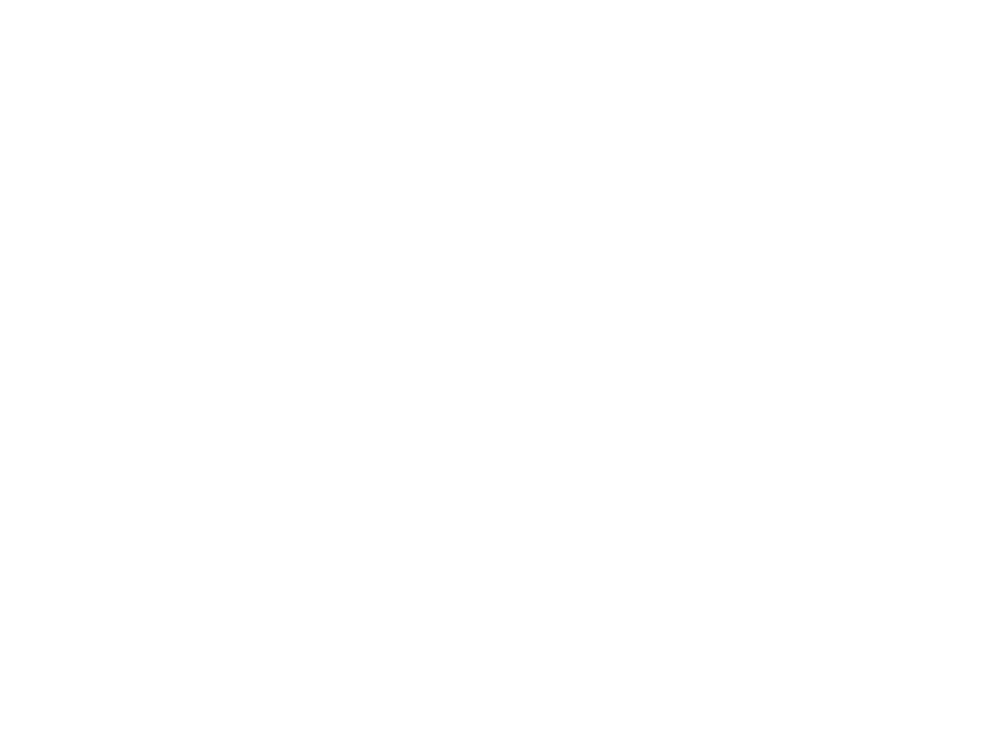

In [30]:
%matplotlib notebook
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

# ヒストグラムを作成（ラベル0は青、ラベル1は赤）
plt.hist([number_data[correct_nucorrect == 0], number_data[correct_nucorrect == 1], number_data[correct_nucorrect == 2]], bins=20, edgecolor='black', alpha=0.5, color=['blue', 'red', 'green'], label=['correct', 'uncorrect', 'unanswerable'])

# グラフにタイトルや軸ラベルを追加
plt.title('領域半径：0.2、占有率境界：60％')
plt.xlabel('Number of data in area')
plt.ylabel('Frequency')

# 凡例を表示
plt.legend()

# ヒストグラムを表示
plt.show()


データ数の条件追加

In [31]:
# 格納用
data=[]
uncorrect_data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.05]
test_radius2=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.5]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]
# print(string_test_radius)
# level0
# level0=string_test_radius
# level0=["0.05～1.5"]
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
number_data2=np.zeros((z_test_np.shape[0],))
correct_nucorrect=np.zeros((z_test_np.shape[0],))
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=90
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level1]
# print(indices)

# データの整理

for index in range(1):
    for l in range(z_test_np.shape[0]):
        # 球状領域の作成
        array=test_radius[index] > calculate_distances(z_test_np[l] ,z_valid_np)
        array2=z_valid_np[array]     
        number_data2[l]=array2.shape[0]
        # 1127：条件追加
        for index_2 in range(len(test_radius2)):
            if number_data2[l] < 1000:
                # 四角形内か否かを判定
                array=test_radius2[index_2] > calculate_distances(z_test_np[l] ,z_valid_np)
                array2=z_valid_np[array]   
                # totalの計算
                number_data2[l]=array2.shape[0]
        # totalの計算
        total_elements=array2.shape[0]
        number_data2[l]=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array]
    #     print(type(array3))
        counts=np.bincount(array3, minlength=10)
        # 結果の表示
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
#             print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
#         print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
#         print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
#         print(f"max_index:{max_index}")
        if para < max_value and total_elements != 0:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
    
    number_data2=number_data2.astype(int)
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            # 代入（可視化用）
            correct_nucorrect[i]=0
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            # 代入（可視化用）
            correct_nucorrect[i]=2
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            # 代入（可視化用）
            correct_nucorrect[i]=1
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            # 不正解を見たい
            uncorrect_data.append(i)
    print(uncorrect_data)
    print(len(uncorrect_data))
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

[12, 23, 42, 43, 68, 98, 141, 147, 153, 222, 241, 244, 325, 332, 344, 361, 381, 382, 404, 441, 444, 454, 525, 639, 684, 711, 715, 732, 760, 787, 859, 934, 947]
33
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
正解,74,99,70,84,67,99,45,95,97,95
不正解,4,1,7,3,4,0,9,2,0,3
解答不可,22,0,23,13,29,1,46,3,3,2


<IPython.core.display.Javascript object>


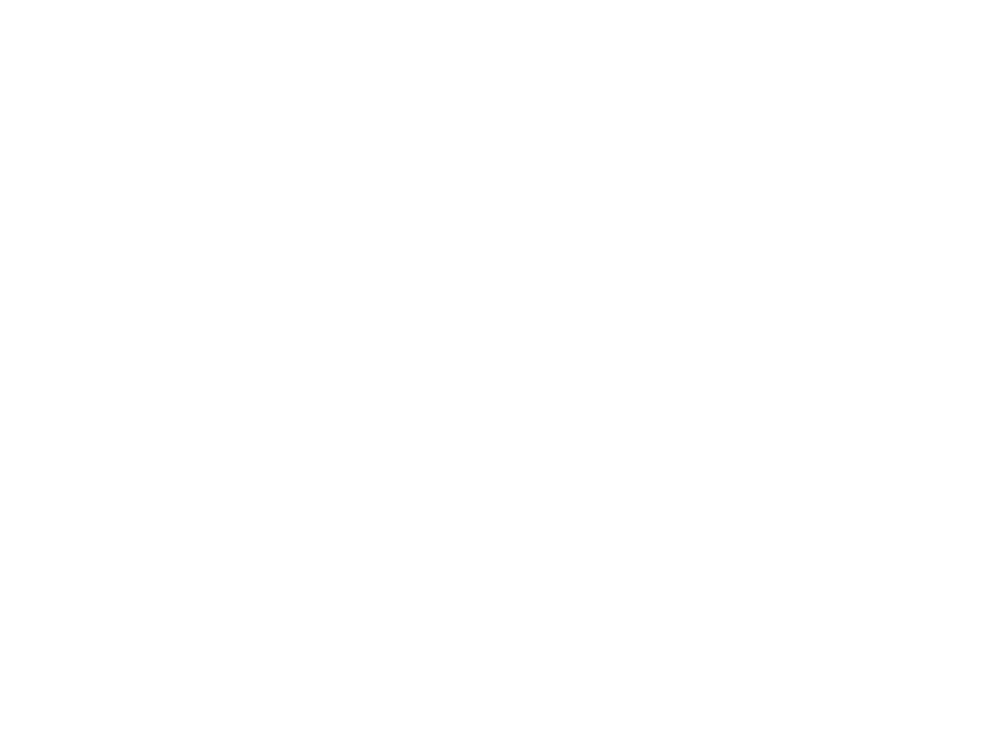

In [32]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# ヒストグラムを作成（ラベル0は青、ラベル1は赤）
plt.hist([number_data2[correct_nucorrect == 0], number_data2[correct_nucorrect == 1], number_data2[correct_nucorrect == 2]], bins=20, edgecolor='black', alpha=0.5, color=['blue', 'red', 'green'], label=['correct', 'uncorrect', 'unanswerable'])

# グラフにタイトルや軸ラベルを追加
plt.title('領域半径：0.05～1.5、占有率境界：90％')
plt.xlabel('Number of data in area')
plt.ylabel('Frequency')

# 凡例を表示
plt.legend()

# ヒストグラムを表示
plt.show()


In [33]:
# 格納用
data=[]
uncorrect_data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.05]
test_radius2=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]
# print(string_test_radius)
# level0
level0=string_test_radius
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
number_data2=np.zeros((z_test_np.shape[0],))
correct_nucorrect=np.zeros((z_test_np.shape[0],))
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=90
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level0, level1]
# print(indices)

# データの整理
sample_data = [np.empty((10000, 3)) for _ in range(z_test_np.shape[0])]
# print(sample_data[0].shape)
sample_label=[np.empty((10000)) for _ in range(z_test_np.shape[0])]
sample_data_dis = np.zeros((z_test_np.shape[0],))
# print(sample_data_dis)
# sample_label_dis=[np.empty((10000)) for _ in range(len(z_test_np.shape[0]))]
# 各クラスの中心格納用
sample_data_means=np.zeros((10, 3))
max_value_his=np.zeros((z_test_np.shape[0],))

for index in range(1):
    for l in range(z_test_np.shape[0]):
        # 四角形内か否かを判定
        array=(z_test_np[l]-test_radius[index] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius[index])
    #     print(array.shape)
        array1=array.all(axis=1)
#         print(array1.shape)
    #     print(array1)
        array2=z_valid_np[array1]   
#         print(array2.shape[0])
        number_data2[l]=array2.shape[0]
        # 1127：条件追加
        for index_2 in range(len(test_radius2)):
            if number_data2[l] < 1000:
                # 四角形内か否かを判定
                array=(z_test_np[l]-test_radius2[index_2] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius2[index_2])
            #     print(array.shape)
                array1=array.all(axis=1)
            #     print(array1.shape)
            #     print(array1)
                array2=z_valid_np[array1]   
            #     print(array2.shape)
                # totalの計算
                number_data2[l]=array2.shape[0]
        sample_data[l]=array2
        # totalの計算
        total_elements=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array1]
    #     print(type(array3))
        sample_label[l]=array3
        counts=np.bincount(array3, minlength=10)
        # 結果の表示
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
#             print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
#         print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
        max_value_his[l]=max_value
#         print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
#         print(f"max_index:{max_index}")

        # 1128条件追加：
        for i in range(class_num):
            sample_data_means[i]=np.mean(sample_data[l][sample_label[l]==i], axis=0)
            # nanを無限大に置き換える
            sample_data_means[i]= np.nan_to_num(sample_data_means[i], nan=np.inf)
#             print(i)
#             print(sample_data_means[i])
#         print(l)
#         print(calculate_distances_normal(sample_data_means[max_index], z_test_np[l]))
#         print(sample_data_dis)
        sample_data_dis[l]=calculate_distances_normal(sample_data_means[max_index], z_test_np[l])
#         print(sample_data_means[i])
        if para < max_value and total_elements != 0:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
    
    number_data2=number_data2.astype(int)
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            # 代入（可視化用）
            correct_nucorrect[i]=0
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            # 代入（可視化用）
            correct_nucorrect[i]=2
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            # 代入（可視化用）
            correct_nucorrect[i]=1
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            # 不正解を見たい
            uncorrect_data.append(i)
    print(uncorrect_data)
    print(len(uncorrect_data))
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[12, 23, 42, 43, 68, 98, 141, 147, 153, 222, 241, 244, 325, 332, 344, 361, 381, 382, 404, 441, 444, 454, 525, 569, 639, 681, 684, 711, 715, 732, 760, 787, 859, 934, 947]
35
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  \
0.05 正解             75       99        70     84    67      99     45   
     不正解             5        1         7      4     4       0      9   
     解答不可           20        0        23     12    29       1     46   

           Sneaker  Bag  Ankle boot  
0.05 正解         96   97          94  
     不正解         2    0           3  
     解答不可        2    3           3

<IPython.core.display.Javascript object>


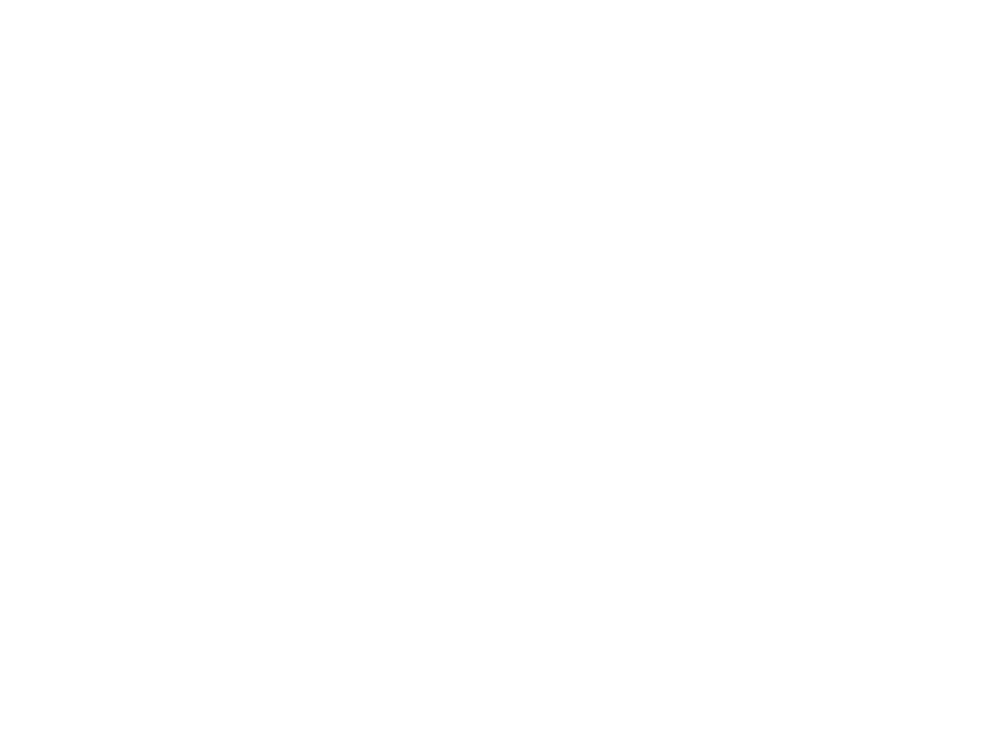

In [34]:
sample_data_dis

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# ヒストグラムを作成（ラベル0は青、ラベル1は赤）
plt.hist([sample_data_dis[correct_nucorrect == 0], sample_data_dis[correct_nucorrect == 1], sample_data_dis[correct_nucorrect == 2]], bins=10, edgecolor='black', alpha=0.5, color=['blue', 'red', 'green'], label=['correct', 'uncorrect', 'unanswerable'])

# グラフにタイトルや軸ラベルを追加
plt.title('Histogram of 1000 Data Points with Labels')
plt.xlabel('Number of data in area')
plt.ylabel('Frequency')

# 凡例を表示
plt.legend()

# ヒストグラムを表示
plt.show()

In [35]:
max_value_his.shape
sample_data_dis[correct_nucorrect == 0].shape

(826,)

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

colors = np.where(correct_nucorrect == 0, 'blue', np.where(correct_nucorrect == 1, 'red','green'))

# 散布図の描画
plt.scatter(sample_data_dis, max_value_his, color=colors)

# ラベルとタイトルの設定
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of Two Variables')

# グリッドの表示
plt.grid(True)

# 凡例の表示
plt.legend()

# 散布図を表示
plt.show()

NameError: name 'correct_nucorrect' is not defined

実際に実装してみる

In [37]:
# 格納用
data=[]
uncorrect_data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.05]
test_radius2=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]
# print(string_test_radius)
# level0
level0=string_test_radius
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
number_data2=np.zeros((z_test_np.shape[0],))
correct_nucorrect=np.zeros((z_test_np.shape[0],))
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=90
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level0, level1]
# print(indices)

# データの整理
sample_data = [np.empty((10000, 3)) for _ in range(z_test_np.shape[0])]
# print(sample_data[0].shape)
sample_label=[np.empty((10000)) for _ in range(z_test_np.shape[0])]
sample_data_dis = np.zeros((z_test_np.shape[0],))
# print(sample_data_dis)
# sample_label_dis=[np.empty((10000)) for _ in range(len(z_test_np.shape[0]))]
# 各クラスの中心格納用
sample_data_means=np.zeros((10, 3))
max_value_his=np.zeros((z_test_np.shape[0],))

for index in range(1):
    for l in range(z_test_np.shape[0]):
        # 四角形内か否かを判定
        array=(z_test_np[l]-test_radius[index] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius[index])
    #     print(array.shape)
        array1=array.all(axis=1)
#         print(array1.shape)
    #     print(array1)
        array2=z_valid_np[array1]   
#         print(array2.shape[0])
        number_data2[l]=array2.shape[0]
        # 1127：条件追加
        for index_2 in range(len(test_radius2)):
            if number_data2[l] < 1000:
                # 四角形内か否かを判定
                array=(z_test_np[l]-test_radius2[index_2] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius2[index_2])
            #     print(array.shape)
                array1=array.all(axis=1)
            #     print(array1.shape)
            #     print(array1)
                array2=z_valid_np[array1]   
            #     print(array2.shape)
                # totalの計算
                number_data2[l]=array2.shape[0]
        sample_data[l]=array2
        # totalの計算
        total_elements=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array1]
    #     print(type(array3))
        sample_label[l]=array3
        counts=np.bincount(array3, minlength=10)
        # 結果の表示
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
#             print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
#         print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
        max_value_his[l]=max_value
#         print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
#         print(f"max_index:{max_index}")

        # 1128条件追加：
        for i in range(class_num):
            sample_data_means[i]=np.mean(sample_data[l][sample_label[l]==i], axis=0)
            # nanを無限大に置き換える
            sample_data_means[i]= np.nan_to_num(sample_data_means[i], nan=np.inf)
            
        sample_data_dis[l]=calculate_distances_normal(sample_data_means[max_index], z_test_np[l])
        counts=np.bincount(array3, minlength=10)
        new_counts=np.copy(counts)
        new_counts[max_index] = counts[max_index] *(1-sample_data_dis[l])
        total_elements=0
        for i in range(10):
            total_elements+=new_counts[i]
        # 結果の表示
        for i in range(10):
            percentage[i] = (new_counts[i] / total_elements) * 100
#             print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
#         print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
        max_value_his[l]=max_value
#         print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
#         print(f"max_index:{max_index}")

#         print(sample_data_means[i])
        if para < max_value and total_elements != 0:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
    
    number_data2=number_data2.astype(int)
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            # 代入（可視化用）
            correct_nucorrect[i]=0
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            # 代入（可視化用）
            correct_nucorrect[i]=2
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            # 代入（可視化用）
            correct_nucorrect[i]=1
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            # 不正解を見たい
            uncorrect_data.append(i)
    print(uncorrect_data)
    print(len(uncorrect_data))
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[12, 23, 42, 43, 68, 98, 147, 153, 222, 241, 244, 325, 332, 344, 361, 381, 382, 441, 444, 525, 531, 639, 684, 711, 715, 732, 760, 787, 859, 947]
30
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  \
0.05 正解             72       99        69     78    64      99     43   
     不正解             3        1         7      2     3       0      9   
     解答不可           25        0        24     20    33       1     48   

           Sneaker  Bag  Ankle boot  
0.05 正解         93   97          94  
     不正解         2    0           3  
     解答不可        5    3           3

In [38]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

colors = np.where(correct_nucorrect == 0, 'blue', np.where(correct_nucorrect == 1, 'red','green'))

# 散布図の描画
plt.scatter(sample_data_dis, max_value_his, color=colors)

# ラベルとタイトルの設定
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of Two Variables')

# グリッドの表示
plt.grid(True)

# 凡例の表示
plt.legend()

# 散布図を表示
plt.show()

<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [39]:
conditions=number_data2 <100
number_data[conditions]
conditions
conditions_data = np.where(conditions)[0]

false_indices = [12, 23, 42, 43, 68, 98, 141, 147, 153, 222, 241, 244, 325, 332, 344, 361, 381, 382, 404, 441, 444, 454, 525, 569, 639, 681, 684, 711, 715, 732, 760, 787, 859, 934, 947]
set1 = set(conditions_data)
set2 = set(false_indices)

common_elements = list(set1.intersection(set2))

def find_difference(list1, list2):
    set1 = set(list1)
    set2 = set(list2)

    difference = set1.symmetric_difference(set2)

    return list(difference)

true_conditions_indices = find_difference(conditions_data, common_elements)
true_conditions_indices

common_elements
y_test_np[12]

7

<IPython.core.display.Javascript object>


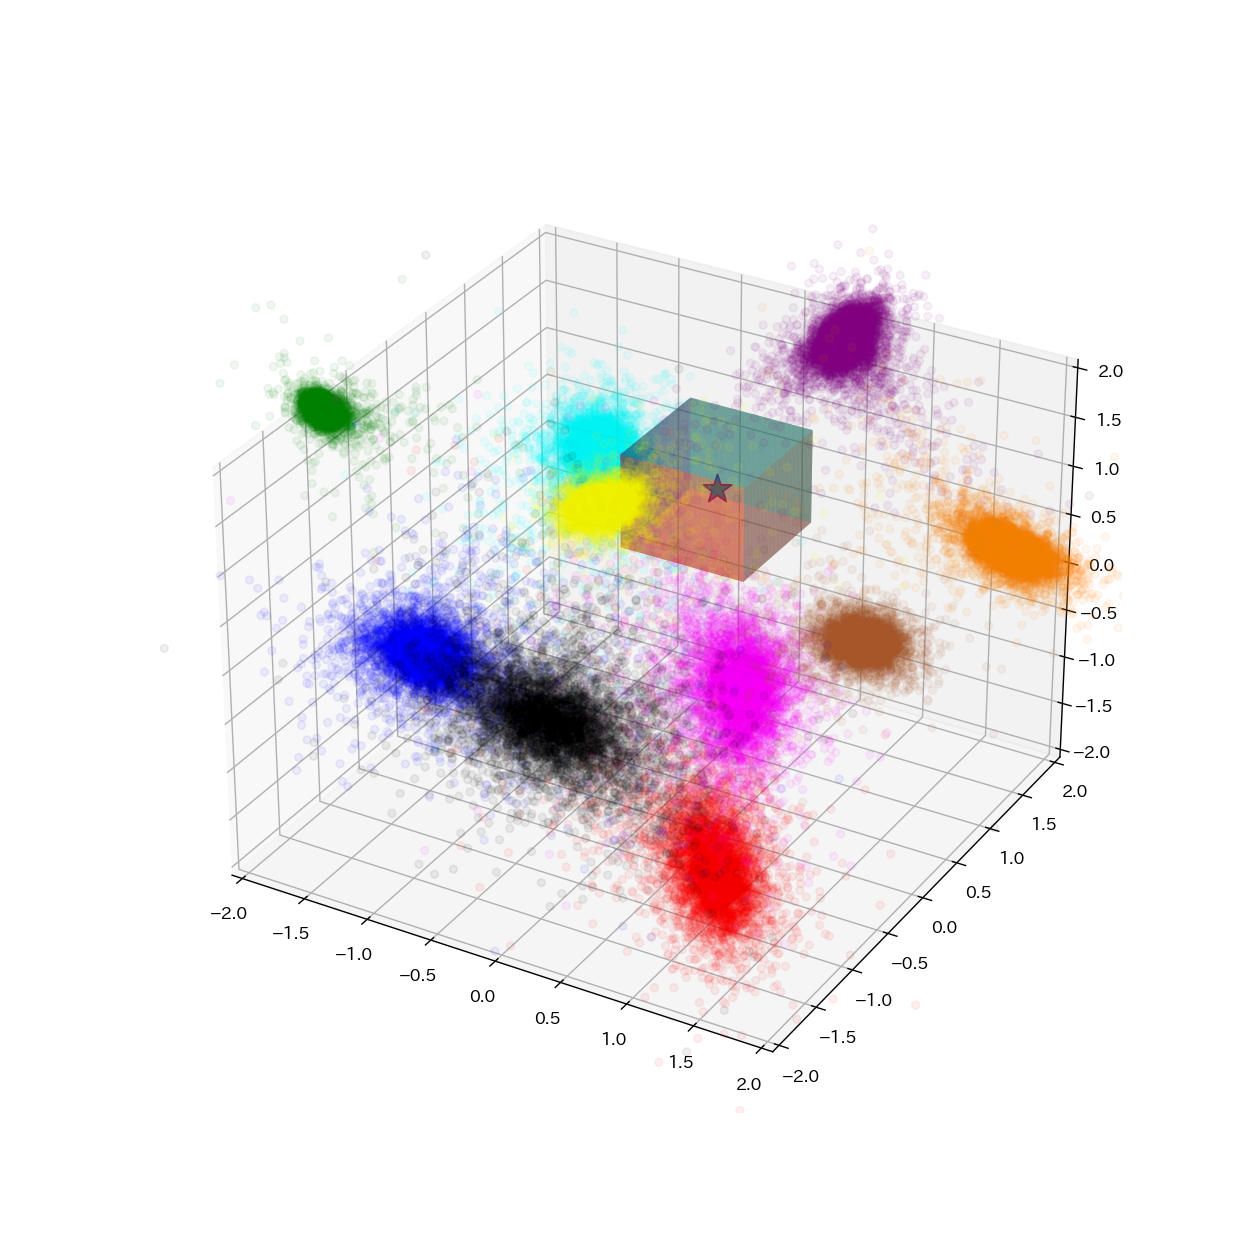

7
Sneaker
purple
--------------------------------------------------------------------
(217, 3)
217
(217,)
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 200 回出現しました。割合は 92.17% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 15 回出現しました。割合は 6.91% です。
クラス 8 は 1 回出現しました。割合は 0.46% です。
クラス 9 は 1 回出現しました。割合は 0.46% です。
--------------------------------------------------------------------
max_value:92.16589861751152
max_index:5
解答は7となる
インデックスは12
--------------------------------------------------------------------


<IPython.core.display.Javascript object>


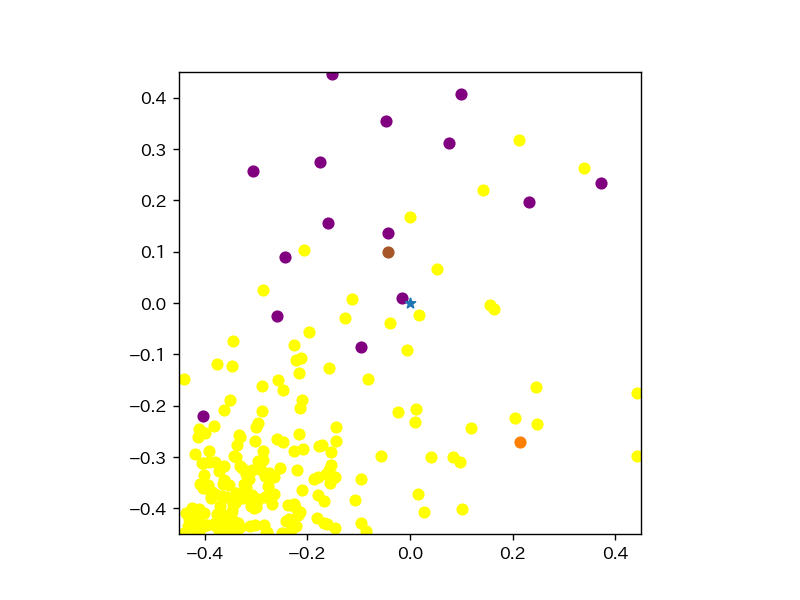

In [44]:
# 可視化

# select=3
for select in range(1):
    # rcParams['figure.figsize'] = 10, 10

    test_radius=[0.45]

    test_ra=test_radius[0]

    x = np.linspace(-test_ra, test_ra, 100)
    y = np.linspace(-test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    Z1 = np.ones_like(X)
    Z2 = -1 * np.ones_like(X)


    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z_test_np[false_indices[select], 0], z_test_np[false_indices[select], 1], z_test_np[false_indices[select], 2], s=300, marker="*", edgecolors=colors[y_test_np[false_indices[select]]])
    x_prime=z_test_np[false_indices[select], 0]
    y_prime=z_test_np[false_indices[select], 1]
    z_prime=z_test_np[false_indices[select], 2]
    ax.plot_surface(X+x_prime, Y+y_prime, Z1+z_prime-1+test_ra, alpha=0.4)
    ax.plot_surface(X+x_prime, Y+y_prime, Z2+z_prime+1-test_ra, alpha=0.4)
    ax.plot_surface(X+x_prime, test_ra+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(X+x_prime, -test_ra+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(test_ra+x_prime, X+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(-test_ra+x_prime, X+y_prime, Y+z_prime, alpha=0.4)

    for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i], alpha=0.06)


    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)

    plt.show()

    # クラス名
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # クラス数
    class_num=len(class_names)
    # 事前に定義された10色のリスト
    colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']

    print(y_test_np[false_indices[select]])
    print(class_names[y_test_np[false_indices[select]]])
    print(colors[y_test_np[false_indices[select]]])

    print("--------------------------------------------------------------------")

    # 割合の表示

    sample_data = [np.empty((60000, 3))]
    sample_label=[np.empty((60000))]
    sample_data

    # for l in range(false_indices[select]):
    l=false_indices[select]
    # 四角形内か否かを判定
    array=(z_test_np[l]-test_radius[index] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius[index])
    #     print(array.shape)
    array1=array.all(axis=1)
    array2=z_valid_np[array1] 
    print(array2.shape)
    # 1103
    sample_data=array2
    total_elements=array2.shape[0]
    print(total_elements)
    # # 1114の条件付け加え
    # if total_elements > 1000:
    #     abc.append(l)
    # labelの確認
    array3=y_valid_np[array1]
    # 1103
    sample_label=array3
    print(array3.shape)
    counts=np.bincount(array3, minlength=10)
    # 結果の表示
    for i in range(10):
        if total_elements==0:
            percentage[i] = (counts[i] / total_elements) * 100
            percentage[i]=0.0
            counts[i]=0
        else:
            percentage[i] = (counts[i] / total_elements) * 100
        print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    print("--------------------------------------------------------------------")
    # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
    #     条件分岐
    max_value = np.max(percentage)
    print(f"max_value:{max_value}")
    max_index = np.argmax(percentage)
    print(f"max_index:{max_index}")
    print(f"解答は{y_test_np[l]}となる")
    print(f"インデックスは{l}")

    print("--------------------------------------------------------------------")
    # 分散
    variance=np.zeros((class_num,3))

    sample_data[i, 0]

    # print(z_valid_np[y_valid_np==0].shape)
    for i in range(class_num):
        variance[i]=np.var(sample_data[sample_label==i], axis=0)
    #     print(variance[i])
    variance

    #
    # 正方形の一辺の長さ
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)

    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



    for i in range(sample_data.shape[0]):
        data_x=sample_data[i, 0]-z_test_np[false_indices[select], 0]
        data_y=sample_data[i, 1]-z_test_np[false_indices[select], 1]
        data_z=sample_data[i, 2]-z_test_np[false_indices[select], 2]
        ax.scatter(data_x, data_y, color=colors[sample_label[i]])

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*")

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()



In [41]:
# 可視化

# select=3
for select in range(10, 30):
    # rcParams['figure.figsize'] = 10, 10

    test_radius=[0.45]

    test_ra=test_radius[0]

    x = np.linspace(-test_ra, test_ra, 100)
    y = np.linspace(-test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    Z1 = np.ones_like(X)
    Z2 = -1 * np.ones_like(X)


    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z_test_np[false_indices[select], 0], z_test_np[false_indices[select], 1], z_test_np[false_indices[select], 2], s=300, marker="*", edgecolors=colors[y_test_np[false_indices[select]]])
    x_prime=z_test_np[false_indices[select], 0]
    y_prime=z_test_np[false_indices[select], 1]
    z_prime=z_test_np[false_indices[select], 2]
    ax.plot_surface(X+x_prime, Y+y_prime, Z1+z_prime-1+test_ra, alpha=0.4)
    ax.plot_surface(X+x_prime, Y+y_prime, Z2+z_prime+1-test_ra, alpha=0.4)
    ax.plot_surface(X+x_prime, test_ra+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(X+x_prime, -test_ra+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(test_ra+x_prime, X+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(-test_ra+x_prime, X+y_prime, Y+z_prime, alpha=0.4)

    for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i], alpha=0.06)


    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)

    plt.show()

    # クラス名
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # クラス数
    class_num=len(class_names)
    # 事前に定義された10色のリスト
    colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']

    print(y_test_np[false_indices[select]])
    print(class_names[y_test_np[false_indices[select]]])
    print(colors[y_test_np[false_indices[select]]])

    print("--------------------------------------------------------------------")

    # 割合の表示

    sample_data = [np.empty((60000, 3))]
    sample_label=[np.empty((60000))]
    sample_data

    # for l in range(false_indices[select]):
    l=false_indices[select]
    # 四角形内か否かを判定
    array=(z_test_np[l]-test_radius[index] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius[index])
    #     print(array.shape)
    array1=array.all(axis=1)
    array2=z_valid_np[array1] 
    print(array2.shape)
    # 1103
    sample_data=array2
    total_elements=array2.shape[0]
    print(total_elements)
    # # 1114の条件付け加え
    # if total_elements > 1000:
    #     abc.append(l)
    # labelの確認
    array3=y_valid_np[array1]
    # 1103
    sample_label=array3
    print(array3.shape)
    counts=np.bincount(array3, minlength=10)
    # 結果の表示
    for i in range(10):
        if total_elements==0:
            percentage[i] = (counts[i] / total_elements) * 100
            percentage[i]=0.0
            counts[i]=0
        else:
            percentage[i] = (counts[i] / total_elements) * 100
        print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    print("--------------------------------------------------------------------")
    # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
    #     条件分岐
    max_value = np.max(percentage)
    print(f"max_value:{max_value}")
    max_index = np.argmax(percentage)
    print(f"max_index:{max_index}")
    print(f"解答は{y_test_np[l]}となる")
    print(f"インデックスは{l}")

    print("--------------------------------------------------------------------")
    # 分散
    variance=np.zeros((class_num,3))

    sample_data[i, 0]

    # print(z_valid_np[y_valid_np==0].shape)
    for i in range(class_num):
        variance[i]=np.var(sample_data[sample_label==i], axis=0)
    #     print(variance[i])
    variance

    #
    # 正方形の一辺の長さ
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)

    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



    for i in range(sample_data.shape[0]):
        data_x=sample_data[i, 0]-z_test_np[false_indices[select], 0]
        data_y=sample_data[i, 1]-z_test_np[false_indices[select], 1]
        data_z=sample_data[i, 2]-z_test_np[false_indices[select], 2]
        ax.scatter(data_x, data_y, color=colors[sample_label[i]])

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*")

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

<IPython.core.display.Javascript object>

6
Shirt
black
--------------------------------------------------------------------
(3715, 3)
3715
(3715,)
クラス 0 は 1 回出現しました。割合は 0.03% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 39 回出現しました。割合は 1.05% です。
クラス 3 は 1 回出現しました。割合は 0.03% です。
クラス 4 は 3641 回出現しました。割合は 98.01% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 33 回出現しました。割合は 0.89% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:98.00807537012113
max_index:4
解答は6となる
インデックスは241
--------------------------------------------------------------------


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:
for select in range(31, 35):
    # rcParams['figure.figsize'] = 10, 10

    test_radius=[0.45]

    test_ra=test_radius[0]

    x = np.linspace(-test_ra, test_ra, 100)
    y = np.linspace(-test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    Z1 = np.ones_like(X)
    Z2 = -1 * np.ones_like(X)


    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z_test_np[false_indices[select], 0], z_test_np[false_indices[select], 1], z_test_np[false_indices[select], 2], s=300, marker="*", edgecolors=colors[y_test_np[false_indices[select]]])
    x_prime=z_test_np[false_indices[select], 0]
    y_prime=z_test_np[false_indices[select], 1]
    z_prime=z_test_np[false_indices[select], 2]
    ax.plot_surface(X+x_prime, Y+y_prime, Z1+z_prime-1+test_ra, alpha=0.4)
    ax.plot_surface(X+x_prime, Y+y_prime, Z2+z_prime+1-test_ra, alpha=0.4)
    ax.plot_surface(X+x_prime, test_ra+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(X+x_prime, -test_ra+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(test_ra+x_prime, X+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(-test_ra+x_prime, X+y_prime, Y+z_prime, alpha=0.4)

    for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i], alpha=0.06)


    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)

    plt.show()

    # クラス名
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # クラス数
    class_num=len(class_names)
    # 事前に定義された10色のリスト
    colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']

    print(y_test_np[false_indices[select]])
    print(class_names[y_test_np[false_indices[select]]])
    print(colors[y_test_np[false_indices[select]]])

    print("--------------------------------------------------------------------")

    # 割合の表示

    sample_data = [np.empty((60000, 3))]
    sample_label=[np.empty((60000))]
    sample_data

    # for l in range(false_indices[select]):
    l=false_indices[select]
    # 四角形内か否かを判定
    array=(z_test_np[l]-test_radius[index] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius[index])
    #     print(array.shape)
    array1=array.all(axis=1)
    array2=z_valid_np[array1] 
    print(array2.shape)
    # 1103
    sample_data=array2
    total_elements=array2.shape[0]
    print(total_elements)
    # # 1114の条件付け加え
    # if total_elements > 1000:
    #     abc.append(l)
    # labelの確認
    array3=y_valid_np[array1]
    # 1103
    sample_label=array3
    print(array3.shape)
    counts=np.bincount(array3, minlength=10)
    # 結果の表示
    for i in range(10):
        if total_elements==0:
            percentage[i] = (counts[i] / total_elements) * 100
            percentage[i]=0.0
            counts[i]=0
        else:
            percentage[i] = (counts[i] / total_elements) * 100
        print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    print("--------------------------------------------------------------------")
    # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
    #     条件分岐
    max_value = np.max(percentage)
    print(f"max_value:{max_value}")
    max_index = np.argmax(percentage)
    print(f"max_index:{max_index}")
    print(f"解答は{y_test_np[l]}となる")
    print(f"インデックスは{l}")

    print("--------------------------------------------------------------------")
    # 分散
    variance=np.zeros((class_num,3))

    sample_data[i, 0]

    # print(z_valid_np[y_valid_np==0].shape)
    for i in range(class_num):
        variance[i]=np.var(sample_data[sample_label==i], axis=0)
    #     print(variance[i])
    variance

    #
    # 正方形の一辺の長さ
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)

    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



    for i in range(sample_data.shape[0]):
        data_x=sample_data[i, 0]-z_test_np[false_indices[select], 0]
        data_y=sample_data[i, 1]-z_test_np[false_indices[select], 1]
        data_z=sample_data[i, 2]-z_test_np[false_indices[select], 2]
        ax.scatter(data_x, data_y, color=colors[sample_label[i]])

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*")

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [ ]:
## 距離関数
def calculate_distances(data1, data2):
    # data1 の各行と data2 とのユークリッド距離を計算
    distances = np.linalg.norm(data1 - data2, axis=1)

    return distances

def calculate_distances_normal(data1, data2):
    # numpyのユークリッド距離関数を使用して距離を計算
    distance = np.linalg.norm(data1 - data2)
    return distance



sample_data[sample_label==6].shape
# 各クラスの中心格納用
sample_data_means=np.zeros((10, 3))
# 中心間距離格納用
test_dis=np.zeros((10,))

# 以下に各クラスごとのクラス中心を算出するプログラムを作成
for i in range(class_num):
    sample_data_means[i]=np.mean(sample_data[sample_label==i], axis=0)
    # nanを無限大に置き換える
    sample_data_means[i]= np.nan_to_num(sample_data_means[i], nan=np.inf)
    print(sample_data_means[i])
    # test dataとの距離を算出
    test_dis[i]=calculate_distances_normal(sample_data_means[i], z_test_np[false_indices[select]])
test_dis

In [ ]:
# z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2]
# 分散
variance=np.zeros((class_num,3))

sample_data[i, 0]

# print(z_valid_np[y_valid_np==0].shape)
for i in range(class_num):
    variance[i]=np.var(sample_data[sample_label==i], axis=0)
#     print(variance[i])
variance

In [ ]:
%matplotlib notebook

print(y_test_np[false_indices[select]])
print(class_names[y_test_np[false_indices[select]]])
print(colors[y_test_np[false_indices[select]]])


# 正方形の一辺の長さ
side_length = 2*test_ra

x = np.linspace(test_ra, test_ra, 100)
y = np.linspace(test_ra, test_ra, 100)
X, Y = np.meshgrid(x, y)

# Z座標をすべて0に設定
Z = np.zeros_like(X)

fig = plt.figure()
ax = fig.add_subplot(111)

# 正方形をプロット
ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



for i in range(sample_data.shape[0]):
    data_x=sample_data[i, 0]-z_test_np[false_indices[select], 0]
    data_y=sample_data[i, 1]-z_test_np[false_indices[select], 1]
    data_z=sample_data[i, 2]-z_test_np[false_indices[select], 2]
    ax.scatter(data_x, data_y, color=colors[sample_label[i]])

for i in range(class_num):
    ax.scatter(sample_data_means[i][0]-z_test_np[false_indices[select], 0], sample_data_means[i][1]-z_test_np[false_indices[select], 1], color=colors[i], marker="*", s=300, edgecolors="white")

ax.set_xlim(-side_length / 2, side_length / 2)
ax.set_ylim(-side_length / 2, side_length / 2)
ax.scatter(0, 0, marker="*")

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
# 可視化
for select in range(8, 15):
# select=1

    # rcParams['figure.figsize'] = 10, 10

    test_radius=[0.8]

    test_ra=test_radius[0]

    x = np.linspace(-test_ra, test_ra, 100)
    y = np.linspace(-test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    Z1 = np.ones_like(X)
    Z2 = -1 * np.ones_like(X)


    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z_test_np[common_elements[select], 0], z_test_np[common_elements[select], 1], z_test_np[common_elements[select], 2], s=300, marker="*", edgecolors=colors[y_test_np[common_elements[select]]])
    x_prime=z_test_np[common_elements[select], 0]
    y_prime=z_test_np[common_elements[select], 1]
    z_prime=z_test_np[common_elements[select], 2]
    ax.plot_surface(X+x_prime, Y+y_prime, Z1+z_prime-1+test_ra, alpha=0.4)
    ax.plot_surface(X+x_prime, Y+y_prime, Z2+z_prime+1-test_ra, alpha=0.4)
    ax.plot_surface(X+x_prime, test_ra+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(X+x_prime, -test_ra+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(test_ra+x_prime, X+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(-test_ra+x_prime, X+y_prime, Y+z_prime, alpha=0.4)

    for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i], alpha=0.06)


    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)

    plt.show()

    # クラス名
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # クラス数
    class_num=len(class_names)
    # 事前に定義された10色のリスト
    colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']

    print(y_test_np[common_elements[select]])
    print(class_names[y_test_np[common_elements[select]]])
    print(colors[y_test_np[common_elements[select]]])

    print("--------------------------------------------------------------------")

    # 割合の表示

    sample_data = [np.empty((60000, 3))]

    sample_label=[np.empty((60000))]
    sample_data

    # for l in range(common_elements[select]):
    l=common_elements[select]
    # 四角形内か否かを判定
    array=(z_test_np[l]-test_radius[index] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius[index])
    #     print(array.shape)
    array1=array.all(axis=1)
    array2=z_valid_np[array1] 
#     print(array2.shape)
    # 1103
    sample_data=array2
    total_elements=array2.shape[0]
    print("total_elements",total_elements)
    # # 1114の条件付け加え
    # if total_elements > 1000:
    #     abc.append(l)
    # labelの確認
    array3=y_valid_np[array1]
    # 1103
    sample_label=array3
#     print(array3.shape)
    counts=np.bincount(array3, minlength=10)
    # 結果の表示
    for i in range(10):
        if total_elements==0:
            percentage[i] = (counts[i] / total_elements) * 100
            percentage[i]=0.0
            counts[i]=0
        else:
            percentage[i] = (counts[i] / total_elements) * 100
        print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    print("--------------------------------------------------------------------")
    # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
    #     条件分岐
    max_value = np.max(percentage)
    print(f"max_value:{max_value}")
    max_index = np.argmax(percentage)
    print(f"max_index:{max_index}")
    print(f"解答は{y_test_np[l]}となる")
    print(f"インデックスは{l}")
    
        variance=np.zeros((class_num,3))
    # print(z_valid_np[y_valid_np==0].shape)
    for i in range(class_num):
        variance[i]=np.var(sample_data[sample_label==i], axis=0)
    print(variance)

    #
    # 正方形の一辺の長さ
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)

    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



    for i in range(sample_data.shape[0]):
        data_x=sample_data[i, 0]-z_test_np[common_elements[select], 0]
        data_y=sample_data[i, 1]-z_test_np[common_elements[select], 1]
        data_z=sample_data[i, 2]-z_test_np[common_elements[select], 2]
        ax.scatter(data_x, data_y, color=colors[sample_label[i]])

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*")

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



    for i in range(sample_data.shape[0]):
        data_x=sample_data[i, 0]-z_test_np[common_elements[select], 0]
        data_y=sample_data[i, 1]-z_test_np[common_elements[select], 1]
        data_z=sample_data[i, 2]-z_test_np[common_elements[select], 2]
        ax.scatter(data_x, data_z, color=colors[sample_label[i]])

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*")

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



    for i in range(sample_data.shape[0]):
        data_x=sample_data[i, 0]-z_test_np[common_elements[select], 0]
        data_y=sample_data[i, 1]-z_test_np[common_elements[select], 1]
        data_z=sample_data[i, 2]-z_test_np[common_elements[select], 2]
        ax.scatter(data_y, data_z, color=colors[sample_label[i]])

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*")

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

========

In [ ]:
# 可視化
for select in range(10):
# select=1

    # rcParams['figure.figsize'] = 10, 10

    test_radius=[0.5]

    test_ra=test_radius[0]

    x = np.linspace(-test_ra, test_ra, 100)
    y = np.linspace(-test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    Z1 = np.ones_like(X)
    Z2 = -1 * np.ones_like(X)


    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z_test_np[false_indices[select], 0], z_test_np[false_indices[select], 1], z_test_np[false_indices[select], 2], s=300, marker="*", edgecolors=colors[y_test_np[false_indices[select]]])
    x_prime=z_test_np[false_indices[select], 0]
    y_prime=z_test_np[false_indices[select], 1]
    z_prime=z_test_np[false_indices[select], 2]
    ax.plot_surface(X+x_prime, Y+y_prime, Z1+z_prime-1+test_ra, alpha=0.4)
    ax.plot_surface(X+x_prime, Y+y_prime, Z2+z_prime+1-test_ra, alpha=0.4)
    ax.plot_surface(X+x_prime, test_ra+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(X+x_prime, -test_ra+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(test_ra+x_prime, X+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(-test_ra+x_prime, X+y_prime, Y+z_prime, alpha=0.4)

    for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i], alpha=0.06)


    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)

    plt.show()

    # クラス名
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # クラス数
    class_num=len(class_names)
    # 事前に定義された10色のリスト
    colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']

    print(y_test_np[false_indices[select]])
    print(class_names[y_test_np[false_indices[select]]])
    print(colors[y_test_np[false_indices[select]]])

    print("--------------------------------------------------------------------")

    # 割合の表示

    sample_data = [np.empty((60000, 3))]

    sample_label=[np.empty((60000))]
    sample_data

    # for l in range(false_indices[select]):
    l=false_indices[select]
    # 四角形内か否かを判定
    array=(z_test_np[l]-test_radius[index] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius[index])
    #     print(array.shape)
    array1=array.all(axis=1)
    array2=z_valid_np[array1] 
#     print(array2.shape)
    # 1103
    sample_data=array2
    total_elements=array2.shape[0]
    print("total_elements",total_elements)
    # # 1114の条件付け加え
    # if total_elements > 1000:
    #     abc.append(l)
    # labelの確認
    array3=y_valid_np[array1]
    # 1103
    sample_label=array3
#     print(array3.shape)
    counts=np.bincount(array3, minlength=10)
    # 結果の表示
    for i in range(10):
        if total_elements==0:
            percentage[i] = (counts[i] / total_elements) * 100
            percentage[i]=0.0
            counts[i]=0
        else:
            percentage[i] = (counts[i] / total_elements) * 100
        print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    print("--------------------------------------------------------------------")
    # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
    #     条件分岐
    max_value = np.max(percentage)
    print(f"max_value:{max_value}")
    max_index = np.argmax(percentage)
    print(f"max_index:{max_index}")
    print(f"解答は{y_test_np[l]}となる")
    print(f"インデックスは{l}")
    
    variance=np.zeros((class_num,3))

    sample_data[i, 0]

    # print(z_valid_np[y_valid_np==0].shape)
    for i in range(class_num):
        variance[i]=np.var(sample_data[sample_label==i], axis=0)
    print(variance)
    

    #
    # 正方形の一辺の長さ
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)

    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



    for i in range(sample_data.shape[0]):
        data_x=sample_data[i, 0]-z_test_np[false_indices[select], 0]
        data_y=sample_data[i, 1]-z_test_np[false_indices[select], 1]
        data_z=sample_data[i, 2]-z_test_np[false_indices[select], 2]
        ax.scatter(data_x, data_y, color=colors[sample_label[i]])

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*")

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [ ]:
# 可視化
for select in range(10, 20):
# select=1

    # rcParams['figure.figsize'] = 10, 10

    test_radius=[0.5]

    test_ra=test_radius[0]

    x = np.linspace(-test_ra, test_ra, 100)
    y = np.linspace(-test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    Z1 = np.ones_like(X)
    Z2 = -1 * np.ones_like(X)


    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z_test_np[select, 0], z_test_np[select, 1], z_test_np[select, 2], s=300, marker="*", edgecolors=colors[y_test_np[select]])
    x_prime=z_test_np[select, 0]
    y_prime=z_test_np[select, 1]
    z_prime=z_test_np[select, 2]
    ax.plot_surface(X+x_prime, Y+y_prime, Z1+z_prime-1+test_ra, alpha=0.4)
    ax.plot_surface(X+x_prime, Y+y_prime, Z2+z_prime+1-test_ra, alpha=0.4)
    ax.plot_surface(X+x_prime, test_ra+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(X+x_prime, -test_ra+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(test_ra+x_prime, X+y_prime, Y+z_prime, alpha=0.4)
    ax.plot_surface(-test_ra+x_prime, X+y_prime, Y+z_prime, alpha=0.4)

    for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i], alpha=0.06)


    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)

    plt.show()

    # クラス名
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # クラス数
    class_num=len(class_names)
    # 事前に定義された10色のリスト
    colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']

    print(y_test_np[select])
    print(class_names[y_test_np[select]])
    print(colors[y_test_np[select]])

    print("--------------------------------------------------------------------")

    # 割合の表示

    sample_data = [np.empty((60000, 3))]

    sample_label=[np.empty((60000))]
    sample_data

    # for l in range(select):
    l=select
    # 四角形内か否かを判定
    array=(z_test_np[l]-test_radius[index] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius[index])
    #     print(array.shape)
    array1=array.all(axis=1)
    array2=z_valid_np[array1] 
#     print(array2.shape)
    # 1103
    sample_data=array2
    total_elements=array2.shape[0]
    print("total_elements",total_elements)
    # # 1114の条件付け加え
    # if total_elements > 1000:
    #     abc.append(l)
    # labelの確認
    array3=y_valid_np[array1]
    # 1103
    sample_label=array3
#     print(array3.shape)
    counts=np.bincount(array3, minlength=10)
    # 結果の表示
    for i in range(10):
        if total_elements==0:
            percentage[i] = (counts[i] / total_elements) * 100
            percentage[i]=0.0
            counts[i]=0
        else:
            percentage[i] = (counts[i] / total_elements) * 100
        print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    print("--------------------------------------------------------------------")
    # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
    #     条件分岐
    max_value = np.max(percentage)
    print(f"max_value:{max_value}")
    max_index = np.argmax(percentage)
    print(f"max_index:{max_index}")
    print(f"解答は{y_test_np[l]}となる")
    print(f"インデックスは{l}")
    
    variance=np.zeros((class_num,3))

    sample_data[i, 0]

    # print(z_valid_np[y_valid_np==0].shape)
    for i in range(class_num):
        variance[i]=np.var(sample_data[sample_label==i], axis=0)
    print(variance)
    

    #
    # 正方形の一辺の長さ
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)

    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



    for i in range(sample_data.shape[0]):
        data_x=sample_data[i, 0]-z_test_np[select, 0]
        data_y=sample_data[i, 1]-z_test_np[select, 1]
        data_z=sample_data[i, 2]-z_test_np[select, 2]
        ax.scatter(data_x, data_y, color=colors[sample_label[i]])

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*")

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()